<a href="https://colab.research.google.com/github/lelenzasan/Projeto_Tarifa_Zero_Curitiba/blob/notebook/Espinha_Dorsal_do_Projeto_TRANSPORTE_CWB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Viabilidade do Passe Livre no Transporte Público de Curitiba

**Definição do Problema:**
O transporte público em Curitiba-PR enfrenta desafios relacionados a custos operacionais, inclusão social e evasão de passageiros pagantes. A implementação do passe livre (tarifa zero) é uma proposta para aumentar o acesso ao transporte, mas sua sustentabilidade financeira é incerta.

**Objetivo do Projeto:**
Analisar se o passe livre aos domingos e feriados é viável financeiramente, considerando os custos para o governo/URBS e o impacto na inclusão de populações de baixa renda. O projeto utilizará dados históricos e os resultados de um experimento real (a meia tarifa) para criar uma simulação e gerar recomendações.

# 1 - Configuração do Ambiente

In [ ]:
# --- 1. Importação das bibliotecas necessárias ---
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import holidays
import seaborn as sns
from prophet import Prophet
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 - Teste de Hipóteses - Aumento de fluxo de passageiros pagantes


**Pergunta:** A diminuição do valor na passagem aos domingos e feriados impactou significativamente o fluxo de passageiros pagantes no transporte público da cidade?

*   H₀: A média de passageiros pagantes é a mesma de outros períodos.
*   H₁: A média de passageiros pagantes é maior após a redução da passagem



In [ ]:
# --- 3. Carregar e Limpar Dados ---
google_sheet_url = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/usuarios_dia.xlsx'
# --- 3.1. Exportando os dados necessários ---
export_url = google_sheet_url.replace('/edit?usp=drive_link', '/export?format=xlsx')
try:
    df = pd.read_excel(export_url)
except Exception as e:
    print(f"Erro em ler o Google Sheet informado: {e}")
    print("Certifique-se de que a planilha esteja compartilhada corretamente ou tente exportá-la como CSV e enviá-la para o Drive.")

Para ler diretamente o arquivo disponibilizado acima, convertemos o link para o formato de exportação CSV ou XLSX. Como é uma planilha, usaremos read_excel com formato de exportação xlsx

Fonte dos dados: https://www.urbs.curitiba.pr.gov.br/transporte/rede-integrada-de-transporte/51

Com o site disponibilizado, basta selecionar a data de interesse (dentro deste projeto estamos utilizando o intervalo de 2020 - 2025). A faixa dos dados coletados foi limitada pela própria fonte.

### 2.1  - Celula 1: Definição da Lista de Feriados
Nesta parte, definimos os feriados dos anos de 2020 até 2025 para realizar uma análise correta e precisa do impacto da Meia Tarifa.



In [ ]:
# Lista completa de feriados nacionais, municipais de Curitiba e pontos facultativos
curitiba_holidays_full = [
    # 2020
    datetime(2020, 1, 1), datetime(2020, 2, 24), datetime(2020, 2, 25), datetime(2020, 2, 26), datetime(2020, 4, 10), datetime(2020, 4, 21), datetime(2020, 5, 1), datetime(2020, 6, 11), datetime(2020, 9, 7), datetime(2020, 9, 8), datetime(2020, 10, 12), datetime(2020, 11, 2), datetime(2020, 11, 15), datetime(2020, 12, 25),
    # 2021
    datetime(2021, 1, 1), datetime(2021, 2, 15), datetime(2021, 2, 16), datetime(2021, 2, 17), datetime(2021, 4, 2), datetime(2021, 4, 21), datetime(2021, 5, 1), datetime(2021, 6, 3), datetime(2021, 9, 7), datetime(2021, 9, 8), datetime(2021, 10, 12), datetime(2021, 11, 2), datetime(2021, 11, 15), datetime(2021, 12, 25),
    # 2022
    datetime(2022, 1, 1), datetime(2022, 2, 28), datetime(2022, 3, 1), datetime(2022, 3, 2), datetime(2022, 4, 15), datetime(2022, 4, 21), datetime(2022, 5, 1), datetime(2022, 6, 16), datetime(2022, 9, 7), datetime(2022, 9, 8), datetime(2022, 10, 12), datetime(2022, 11, 2), datetime(2022, 11, 15), datetime(2022, 12, 25),
    # 2023
    datetime(2023, 1, 1), datetime(2023, 2, 20), datetime(2023, 2, 21), datetime(2023, 2, 22), datetime(2023, 4, 7), datetime(2023, 4, 21), datetime(2023, 5, 1), datetime(2023, 6, 8), datetime(2023, 9, 7), datetime(2023, 9, 8), datetime(2023, 10, 12), datetime(2023, 11, 2), datetime(2023, 11, 15), datetime(2023, 12, 25),
    # 2024
    datetime(2024, 1, 1), datetime(2024, 2, 12), datetime(2024, 2, 13), datetime(2024, 2, 14), datetime(2024, 3, 29), datetime(2024, 4, 21), datetime(2024, 5, 1), datetime(2024, 5, 30), datetime(2024, 9, 7), datetime(2024, 9, 8), datetime(2024, 10, 12), datetime(2024, 11, 2), datetime(2024, 11, 15), datetime(2024, 11, 20), datetime(2024, 12, 25),
    # 2025
    datetime(2025, 1, 1), datetime(2025, 3, 3), datetime(2025, 3, 4), datetime(2025, 3, 5), datetime(2025, 4, 18), datetime(2025, 4, 21), datetime(2025, 5, 1), datetime(2025, 6, 19), datetime(2025, 9, 7), datetime(2025, 9, 8), datetime(2025, 10, 12), datetime(2025, 11, 2), datetime(2025, 11, 15), datetime(2025, 11, 20), datetime(2025, 12, 25)
]
holidays_set = set(d.date() for d in curitiba_holidays_full)

### 2.2 - Celula 2: Carga e Tratamento Inicial dos Dados
Nesta célula, carregamos o arquivo Excel e preparamos o DataFrame principal (df_cleaned) que será a base para AMBAS as análises.

In [ ]:
# Especifique o caminho exato do seu arquivo no Google Drive
file_path = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/usuarios_dia.xlsx'

# Lendo o arquivo Excel com a função pd.read_excel
df = pd.read_excel(file_path)

# Convertendo a coluna 'DATA' para o formato de data (datetime)
df['DATA'] = pd.to_datetime(df['DATA'], format='%d de %b. de %Y', errors='coerce')

# Removendo qualquer linha que tenha falhado na conversão da data
df_cleaned = df.dropna(subset=['DATA']).copy()

# Criando as colunas calculadas que serão usadas em todas as análises
df_cleaned['TOTAL_PASSAGEIROS'] = df_cleaned['TOTAL S/ ISENTOS'] + df_cleaned['Passageiros Isentos']
df_cleaned['DIA_SEMANA'] = df_cleaned['DATA'].dt.weekday

# Função para classificar cada linha do DataFrame
def classifica_dia(row):
    data = row['DATA'].date()
    if data in holidays_set: return 'Feriado'
    elif row['DIA_SEMANA'] == 6: return 'Domingo'
    elif row['DIA_SEMANA'] == 5: return 'Sábado'
    else: return 'Dia Útil'

# Aplicando a função para criar a coluna 'TIPO_DIA'
df_cleaned['TIPO_DIA'] = df_cleaned.apply(classifica_dia, axis=1)

print("DataFrame principal preparado com sucesso!")
print(f"Total de registros: {len(df_cleaned)}")
print("Amostra dos dados:")
print(df_cleaned.head())

DataFrame principal preparado com sucesso!
Total de registros: 853
Amostra dos dados:
        DATA  TOTAL S/ ISENTOS  Passageiros Isentos  TOTAL_PASSAGEIROS  \
0 2020-03-01            117109                27918             145027   
1 2020-03-02            615010               100508             715518   
2 2020-03-03            630057               102958             733015   
3 2020-03-04            639283               109205             748488   
4 2020-03-05            640561               106268             746829   

   DIA_SEMANA  TIPO_DIA  
0           6   Domingo  
1           0  Dia Útil  
2           1  Dia Útil  
3           2  Dia Útil  
4           3  Dia Útil  


### 2.3 Célula 3: Análise 1 - Impacto da Pandemia
Aqui realizamos a primeira análise, focada em visualizar e quantificar o efeito da pandemia no transporte público.

--- INICIANDO ANÁLISE 1: IMPACTO DA PANDEMIA ---

--- Média de Passageiros por Período da Pandemia ---
                 PERIODO_PANDEMIA  TIPO_DIA  TOTAL_PASSAGEIROS
0   Auge da Pandemia (Restrições)  Dia Útil          332580.04
1   Auge da Pandemia (Restrições)   Domingo           70542.69
2   Auge da Pandemia (Restrições)   Feriado          103845.71
3   Auge da Pandemia (Restrições)    Sábado          164911.19
4                    Pré-Pandemia  Dia Útil          713112.67
5                    Pré-Pandemia   Domingo          148764.67
6                    Pré-Pandemia    Sábado          326478.50
7      Pós-Pandemia (Recuperação)  Dia Útil          539548.02
8      Pós-Pandemia (Recuperação)   Domingo          118239.53
9      Pós-Pandemia (Recuperação)   Feriado          181503.05
10     Pós-Pandemia (Recuperação)    Sábado          246479.19

--- Gerando Gráfico: Série Temporal Completa (2020-2025) ---


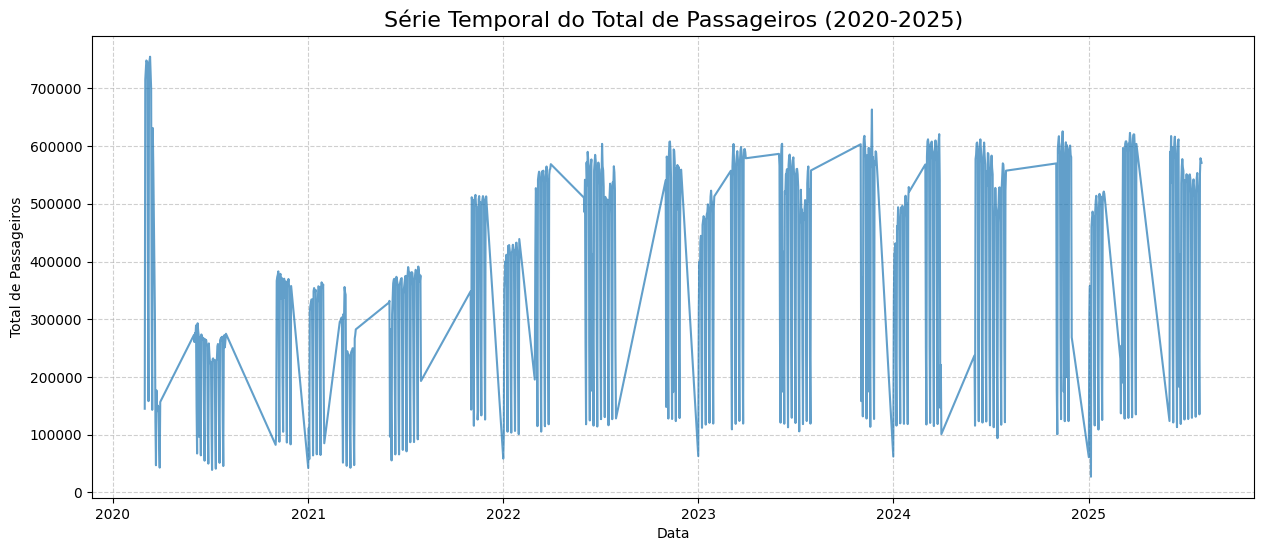


--- Gerando Gráfico: Comparativo de Passageiros por Período ---


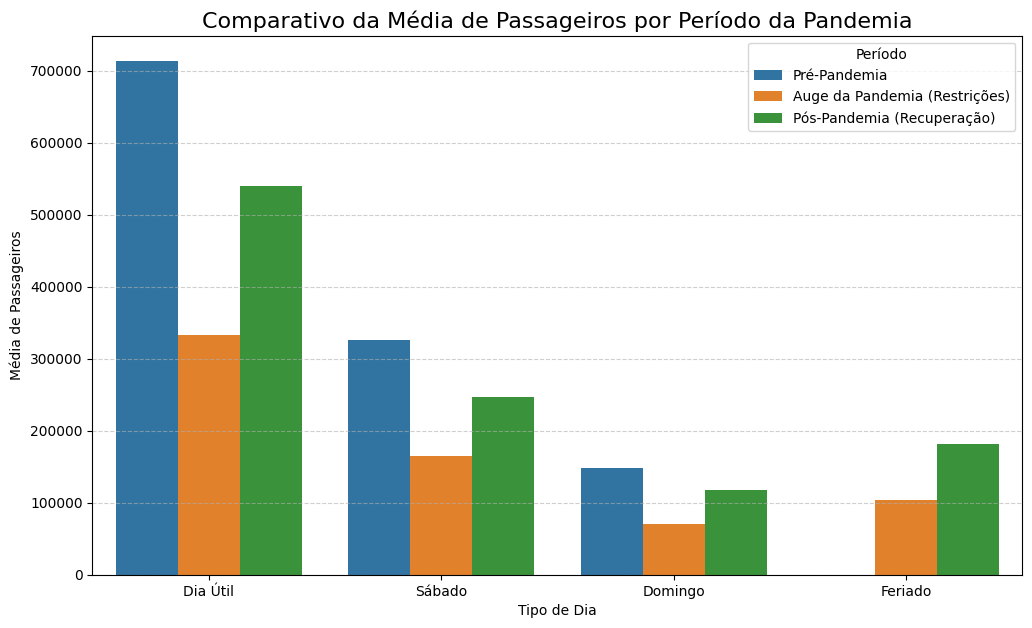

In [ ]:
print("--- INICIANDO ANÁLISE 1: IMPACTO DA PANDEMIA ---")

# 1. Definir os períodos da pandemia para análise
def classifica_periodo_pandemia(data):
    if data < datetime(2020, 3, 18):
        return 'Pré-Pandemia'
    elif data <= datetime(2021, 12, 31):
        return 'Auge da Pandemia (Restrições)'
    else:
        return 'Pós-Pandemia (Recuperação)'

df_cleaned['PERIODO_PANDEMIA'] = df_cleaned['DATA'].apply(classifica_periodo_pandemia)

# 2. Calcular a média de passageiros por período e tipo de dia
media_passageiros_pandemia = df_cleaned.groupby(['PERIODO_PANDEMIA', 'TIPO_DIA'])['TOTAL_PASSAGEIROS'].mean().round(2).reset_index()
print("\n--- Média de Passageiros por Período da Pandemia ---")
print(media_passageiros_pandemia)

# 3. Visualização: Série Temporal Completa
print("\n--- Gerando Gráfico: Série Temporal Completa (2020-2025) ---")
plt.figure(figsize=(15, 6))
sns.lineplot(x='DATA', y='TOTAL_PASSAGEIROS', data=df_cleaned, alpha=0.7)
plt.title('Série Temporal do Total de Passageiros (2020-2025)', fontsize=16)
plt.ylabel('Total de Passageiros')
plt.xlabel('Data')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4. Visualização: Comparativo em Gráfico de Barras
print("\n--- Gerando Gráfico: Comparativo de Passageiros por Período ---")
plt.figure(figsize=(12, 7))
sns.barplot(x='TIPO_DIA', y='TOTAL_PASSAGEIROS', hue='PERIODO_PANDEMIA', data=media_passageiros_pandemia,
            order=['Dia Útil', 'Sábado', 'Domingo', 'Feriado'],
            hue_order=['Pré-Pandemia', 'Auge da Pandemia (Restrições)', 'Pós-Pandemia (Recuperação)'])
plt.title('Comparativo da Média de Passageiros por Período da Pandemia', fontsize=16)
plt.ylabel('Média de Passageiros')
plt.xlabel('Tipo de Dia')
plt.legend(title='Período')
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

### 2.4 Célula 4: Análise 2 - Preparação dos Dados da Redução da Tarifa
Agora, preparamos o terreno para a segunda análise, filtrando e segmentando os dados especificamente para o estudo da meia tarifa.

In [ ]:
print("\n--- INICIANDO ANÁLISE 2: IMPACTO DA REDUÇÃO DA TARIFA ---")

# 1. Filtrando o DataFrame para manter apenas Domingos e Feriados
df_dom_fer = df_cleaned[df_cleaned['TIPO_DIA'].isin(['Domingo', 'Feriado'])].copy()

# 2. Definindo a data de início da política de meia tarifa
data_corte = datetime(2025, 1, 5)

# 3. Criando a coluna 'PERIODO' para separar os dados em antes e depois
df_dom_fer['PERIODO'] = df_dom_fer['DATA'].apply(lambda x: 'Antes' if x < data_corte else 'Depois')

print("\n--- Dados para Análise da Tarifa Prontos ---")
print("Amostra dos dados:")
print(df_dom_fer[['DATA', 'TOTAL S/ ISENTOS', 'TIPO_DIA', 'PERIODO']].head())


--- INICIANDO ANÁLISE 2: IMPACTO DA REDUÇÃO DA TARIFA ---

--- Dados para Análise da Tarifa Prontos ---
Amostra dos dados:
         DATA  TOTAL S/ ISENTOS TIPO_DIA PERIODO
0  2020-03-01            117109  Domingo   Antes
7  2020-03-08            128466  Domingo   Antes
14 2020-03-15            117792  Domingo   Antes
21 2020-03-22             39697  Domingo   Antes
28 2020-03-29             36270  Domingo   Antes


###2.5 Célula 5: Análise da Tarifa - Visualizações
Com os dados da tarifa preparados, geramos os gráficos de boxplot e a série temporal focada.


--- Gerando Gráfico: Boxplot (Antes vs. Depois) ---


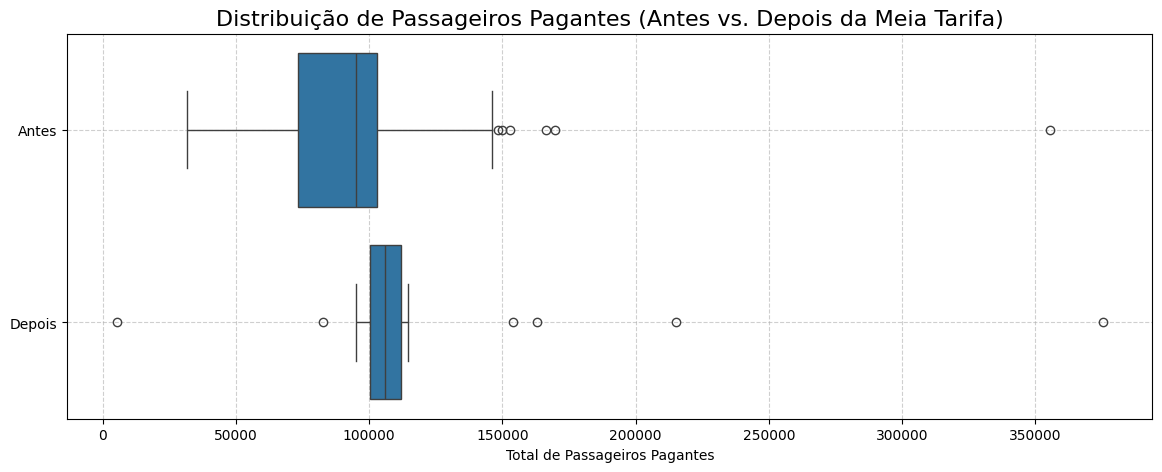


--- Gerando Gráfico: Série Temporal Focada na Mudança de Tarifa ---


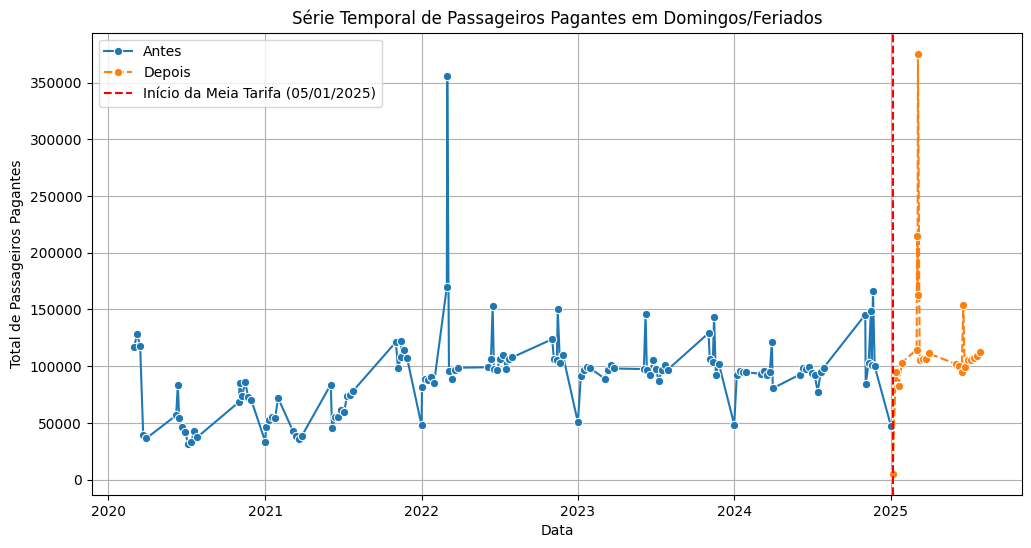

In [ ]:
# 1. Gerando o Boxplot
print("\n--- Gerando Gráfico: Boxplot (Antes vs. Depois) ---")
plt.figure(figsize=(14, 5))
sns.boxplot(x='TOTAL S/ ISENTOS', y='PERIODO', data=df_dom_fer, order=['Antes', 'Depois'])
plt.title('Distribuição de Passageiros Pagantes (Antes vs. Depois da Meia Tarifa)', fontsize=16)
plt.xlabel('Total de Passageiros Pagantes')
plt.ylabel('')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. Gerando o Gráfico de Linha
print("\n--- Gerando Gráfico: Série Temporal Focada na Mudança de Tarifa ---")
plt.figure(figsize=(12, 6))
sns.lineplot(x='DATA', y='TOTAL S/ ISENTOS', data=df_dom_fer, marker='o', hue='PERIODO', style='PERIODO')
plt.axvline(x=data_corte, color='r', linestyle='--', label='Início da Meia Tarifa (05/01/2025)')
plt.title('Série Temporal de Passageiros Pagantes em Domingos/Feriados')
plt.xlabel('Data')
plt.ylabel('Total de Passageiros Pagantes')
plt.legend()
plt.grid(True)
plt.show()

###2.6 Análise da Inferencial - Teste de Hipótese
Realizamos o teste estatístico para validar se a mudança observada é significativa e apresentamos as conclusões.

In [ ]:
print("\n--- Executando Teste de Hipótese (Teste t) ---")

# 1. Separando as amostras
antes = df_dom_fer[df_dom_fer['PERIODO'] == 'Antes']['TOTAL S/ ISENTOS']
depois = df_dom_fer[df_dom_fer['PERIODO'] == 'Depois']['TOTAL S/ ISENTOS']

# 2. Realizando o Teste t
t_stat, p_val = stats.ttest_ind(depois, antes, alternative='greater', equal_var=False) # Usando Welch's t-test

print(f'\nEstatística t: {t_stat:.4f}')
print(f'P-valor: {p_val:.4f}')

# 3. Interpretando o resultado
if p_val < 0.05:
    print('Conclusão: Rejeitamos H0. Há um aumento estatisticamente significativo na média de passageiros.')
else:
    print('Conclusão: Não rejeitamos H0. Não há evidência suficiente para comprovar um aumento na média.')

# 4. Calculando as métricas de impacto
media_antes = antes.mean()
media_depois = depois.mean()
diferenca_medias = media_depois - media_antes
aumento_percentual = (diferenca_medias / media_antes) * 100

print("\n--- Métricas de Impacto da Meia Tarifa ---")
print(f'Média de passageiros pagantes (Antes): {media_antes:,.0f}')
print(f'Média de passageiros pagantes (Depois): {media_depois:,.0f}')
print(f'Aumento na média de passageiros: {diferenca_medias:,.0f}')
print(f'Aumento percentual: {aumento_percentual:.2f}%')


--- Executando Teste de Hipótese (Teste t) ---

Estatística t: 2.0567
P-valor: 0.0255
Conclusão: Rejeitamos H0. Há um aumento estatisticamente significativo na média de passageiros.

--- Métricas de Impacto da Meia Tarifa ---
Média de passageiros pagantes (Antes): 91,084
Média de passageiros pagantes (Depois): 121,522
Aumento na média de passageiros: 30,438
Aumento percentual: 33.42%


###2.7 Célula : Cálculo de KPIs
Para avaliar o impacto real da política de meia tarifa, esta análise vai além da simples variação de passageiros. Os Indicadores-Chave de Performance (KPIs) a seguir foram estruturados para quantificar os resultados e responder às perguntas de negócio centrais:

- Qual foi o aumento real da demanda (incluindo pagantes e isentos)?

- Qual é o impacto financeiro líquido (custo vs. receita) dessa mudança?

Para responder a essas perguntas com precisão, a análise se baseia em duas premissas metodológicas críticas que garantem a exatidão dos resultados:

**Passageiros Isentos Geram Custo:** A análise de custo operacional é calculada com base no total de passageiros transportados (pagantes + isentos), pois todos utilizam a capacidade do sistema. Ignorar os isentos subestimaria o custo real da política.

**A Tarifa Técnica é Variável:** O custo operacional por passageiro não é um valor fixo. Esta análise utiliza a tarifa técnica média específica de cada ano, garantindo uma comparação financeira justa entre os períodos "Antes" (2020-2024) e "Depois" (2025).

In [ ]:
# Separando a tabela da evolução da tarifa técnica nos anos de 2020-2025
df_tarifa_tecnica = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/1.1-evolucao_tarifa_tec_2010-2023.csv'
df_tarifa_tecnica = pd.read_csv(df_tarifa_tecnica)
df_tarifa_tecnica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   web-scraper-order                  89 non-null     object
 1   web-scraper-start-url              89 non-null     object
 2   Nº_Ato_resolução                   87 non-null     object
 3   Data do Ato                        87 non-null     object
 4   Data da Tarifa                     87 non-null     object
 5   Tarifa Técnica                     87 non-null     object
 6   Custo_km                           87 non-null     object
 7   IPK                                87 non-null     object
 8   Passageiros Pagantes Equivalentes  87 non-null     object
 9   Quilometragem Média Mensal         87 non-null     object
 10  Frota Operante                     87 non-null     object
dtypes: object(11)
memory usage: 7.8+ KB


In [ ]:
# Convertendo a coluna 'Data da Tarifa' para datetime com o formato correto
df_tarifa_tecnica['Data da Tarifa'] = pd.to_datetime(df_tarifa_tecnica['Data da Tarifa'], format='%d/%m/%Y', errors='coerce', dayfirst=True)

# Convertendo a coluna 'Tarifa Técnica' para numérico, substituindo vírgulas por pontos
df_tarifa_tecnica['Tarifa Técnica'] = df_tarifa_tecnica['Tarifa Técnica'].astype(str).str.replace(',', '.', regex=False).astype(float)

df_tarifa_tecnica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   web-scraper-order                  89 non-null     object        
 1   web-scraper-start-url              89 non-null     object        
 2   Nº_Ato_resolução                   87 non-null     object        
 3   Data do Ato                        87 non-null     object        
 4   Data da Tarifa                     87 non-null     datetime64[ns]
 5   Tarifa Técnica                     87 non-null     float64       
 6   Custo_km                           87 non-null     object        
 7   IPK                                87 non-null     object        
 8   Passageiros Pagantes Equivalentes  87 non-null     object        
 9   Quilometragem Média Mensal         87 non-null     object        
 10  Frota Operante                     87 no

In [ ]:
# Filtrando o DataFrame para manter apenas as colunas de interesse
df_tarifa_filtrada = df_tarifa_tecnica[['Data da Tarifa', 'Tarifa Técnica']].copy()

# Removendo linhas com valores nulos nas colunas de interesse
df_tarifa_filtrada.dropna(subset=['Data da Tarifa', 'Tarifa Técnica'], inplace=True)

# Exibindo as primeiras linhas do DataFrame filtrado e limpo
print("DataFrame filtrado e limpo com 'Data da Tarifa' e 'Tarifa Técnica':")
df_tarifa_filtrada.head(90)

DataFrame filtrado e limpo com 'Data da Tarifa' e 'Tarifa Técnica':


,Data da Tarifa,Tarifa Técnica
1,2025-08-01,8.1410
2,2025-07-01,7.4843
3,2025-06-01,7.9164
4,2025-05-01,7.5518
5,2025-04-01,7.6105
...,...,...
84,2012-12-01,2.8983
85,2012-08-01,2.8723
86,2012-02-26,2.7880
87,2011-02-26,2.5659


In [ ]:
# Extrair o ano da coluna 'Data da Tarifa'
df_tarifa_filtrada['ANO'] = df_tarifa_filtrada['Data da Tarifa'].dt.year

# Filtrar os dados para os anos de 2020 a 2025
df_tarifa_anos_interesse = df_tarifa_filtrada[(df_tarifa_filtrada['ANO'] >= 2020) & (df_tarifa_filtrada['ANO'] <= 2025)].copy()

# Agrupar por ano e calcular a média da Tarifa Técnica
df_tarifa_media_anual = df_tarifa_anos_interesse.groupby('ANO')['Tarifa Técnica'].mean().reset_index()

# Exibir o DataFrame resultante
print("Média da Tarifa Técnica por Ano (2020-2025):")
display(df_tarifa_media_anual)

Média da Tarifa Técnica por Ano (2020-2025):


,ANO,Tarifa Técnica
0,2020,5.340250
1,2021,8.068200
2,2022,6.695910
3,2023,7.102036
4,2024,7.085215
5,2025,7.958975


In [ ]:
# --- Definição dos nomes dos arquivos ---

file_path_kpis = '/content/drive/MyDrive/dados_processados_pagantes_curitiba_holidays.csv'
output_file = '/content/drive/MyDrive/kpis_meia_tarifa_dom_fer_REVISADO.xlsx'

# Verificar se o DataFrame df_tarifa_media_anual existe
if 'df_tarifa_media_anual' not in locals():
    print("ERRO: O DataFrame 'df_tarifa_media_anual' não foi encontrado.")
    print("Por favor, execute o 'Código 1: Preparação da Tarifa' primeiro.")
else:
    try:
        # --- Carregar dados de passageiros ---
        print(f"Carregando dados de passageiros: {file_path_kpis}")
        df_kpis = pd.read_csv(file_path_kpis)
        print("Dados de passageiros carregados.")

        print("Usando 'df_tarifa_media_anual' da memória.")

        # --- Preparar e Limpar dados de passageiros (df_kpis) ---
        print("Iniciando limpeza e preparação dos dados de passageiros...")

        df_kpis['DATA'] = pd.to_datetime(df_kpis['DATA'], errors='coerce')
        df_kpis = df_kpis.dropna(subset=['DATA']).copy()
        df_kpis['Ano'] = df_kpis['DATA'].dt.year

        # Renomeia as colunas (fundamental para a lógica correta)
        df_kpis = df_kpis.rename(columns={
            'TOTAL S/ ISENTOS': 'pagantes',
            'Passageiros Isentos': 'isentos',
            'TOTAL_PASSAGEIROS': 'total_passageiros'
        })
        print("Colunas renomeadas: 'pagantes', 'isentos', 'total_passageiros'")

        # --- Mapear Tarifa Técnica Anual ---
        df_tarifa_pronto = df_tarifa_media_anual.rename(columns={
            'ANO': 'Ano',
            'Tarifa Técnica': 'Tarifa_Tecnica_Media'
        })

        print("Mapeando tarifa técnica média anual para cada dia...")
        df_kpis = pd.merge(
            df_kpis,
            df_tarifa_pronto, # Usando o DataFrame da memória
            on='Ano',
            how='left'
        )

        # Tratamento de Nulos (se houver)
        if df_kpis['Tarifa_Tecnica_Media'].isnull().any():
            print("Aviso: Alguns dias não tiveram uma tarifa técnica correspondente.")
            valor_2025 = df_tarifa_pronto[df_tarifa_pronto['Ano'] == 2025]['Tarifa_Tecnica_Media'].values[0]
            df_kpis['Tarifa_Tecnica_Media'] = df_kpis['Tarifa_Tecnica_Media'].fillna(valor_2025)
            print(f"Valores nulos preenchidos com a tarifa de 2025 (R$ {valor_2025:.4f})")

        print("Tarifa técnica mapeada.")

        # --- Definir Períodos e Parâmetros Financeiros ---
        data_corte = datetime(2025, 1, 5)
        df_kpis['PERIODO'] = df_kpis['DATA'].apply(lambda x: 'Antes' if x < data_corte else 'Depois')

        tarifa_inteira = 6.00
        tarifa_meia = 3.00

        print(f"Períodos definidos. Corte em: {data_corte.date()}")

        # --- Criar Colunas de Custo e Receita (Lógica Correta) ---

        # Receita = baseada APENAS em 'pagantes'
        df_kpis['Receita_Estimada'] = np.where(
            df_kpis['PERIODO'] == 'Antes',
            df_kpis['pagantes'] * tarifa_inteira,
            df_kpis['pagantes'] * tarifa_meia
        )

        # Custo = baseado em 'total_passageiros' e na tarifa técnica do ano
        df_kpis['Custo_Estimado'] = df_kpis['total_passageiros'] * df_kpis['Tarifa_Tecnica_Media']

        print("Colunas 'Receita_Estimada' e 'Custo_Estimado' calculadas por dia.")

        # --- Agregar por Período ---
        print("Agregando resultados por período ('Antes' e 'Depois')...")
        agg_df = df_kpis.groupby('PERIODO').agg(
            dias=('DATA', 'nunique'),
            media_pagantes=('pagantes', 'mean'),
            media_isentos=('isentos', 'mean'),
            media_total_passageiros=('total_passageiros', 'mean'),
            media_receita_diaria=('Receita_Estimada', 'mean'),
            media_custo_diario=('Custo_Estimado', 'mean')
        ).reindex(['Antes', 'Depois']).reset_index() # Garantir a ordem

        antes = agg_df[agg_df['PERIODO'] == 'Antes'].iloc[0]
        depois = agg_df[agg_df['PERIODO'] == 'Depois'].iloc[0]

        # --- Cálculo Final dos KPIs ---
        print("Calculando KPIs finais...")

        delta_passageiros_pagantes = depois['media_pagantes'] - antes['media_pagantes']
        delta_pagantes_percentual = (delta_passageiros_pagantes / antes['media_pagantes'] * 100)
        delta_passageiros_total = depois['media_total_passageiros'] - antes['media_total_passageiros']
        delta_total_percentual = (delta_passageiros_total / antes['media_total_passageiros'] * 100)
        perda_receita_dia = antes['media_receita_diaria'] - depois['media_receita_diaria']
        perda_receita_percentual = (perda_receita_dia / antes['media_receita_diaria'] * 100)
        aumento_custo_dia = depois['media_custo_diario'] - antes['media_custo_diario']
        aumento_custo_percentual = (aumento_custo_dia / antes['media_custo_diario'] * 100)
        impacto_liquido_dia = perda_receita_dia + aumento_custo_dia

        # --- Resultados Finais ---
        print("\n" + "="*54)
        print("KPIs: Impacto Quantitativo da Meia Tarifa")
        print("(Domingos e Feriados - 2020-2025)")
        print("="*54)
        print(f"Período 'Antes': {antes['dias']} dias | Período 'Depois': {depois['dias']} dias")

        print("\n--- 1. Análise de Passageiros ---")
        print(f"Média Pagantes/dia (Antes):   {antes['media_pagantes']:,.0f}")
        print(f"Média Pagantes/dia (Depois):  {depois['media_pagantes']:,.0f}")
        print(f"Δ Pagantes:                   {delta_passageiros_pagantes:,.0f} ({delta_pagantes_percentual:+.2f}%)")
        print(f"Média Total Passageiros/dia (Antes):   {antes['media_total_passageiros']:,.0f}")
        print(f"Média Total Passageiros/dia (Depois):  {depois['media_total_passageiros']:,.0f}")
        print(f"Δ Total Passageiros:          {delta_passageiros_total:,.0f} ({delta_total_percentual:+.2f}%)")

        print("\n--- 2. Análise de Receita (Baseada em Pagantes) ---")
        print(f"Receita Média Diária (Antes):   R$ {antes['media_receita_diaria']:,.2f}")
        print(f"Receita Média Diária (Depois):  R$ {depois['media_receita_diaria']:,.2f}")
        print(f"Perda de Receita Média Diária:  R$ {perda_receita_dia:,.2f} ({perda_receita_percentual:.2f}%)")

        print("\n--- 3. Análise de Custo (Baseada em Total e Tarifa Técnica Anual) ---")
        print(f"Custo Operacional Médio Diário (Antes):   R$ {antes['media_custo_diario']:,.2f}")
        print(f"Custo Operacional Médio Diário (Depois):  R$ {depois['media_custo_diario']:,.2f}")
        print(f"Aumento Custo Operacional Diário:       R$ {aumento_custo_dia:,.2f} ({aumento_custo_percentual:.2f}%)")

        print("\n--- 4. Resultado Líquido (Subsídio) ---")
        print(f"Perda de Receita Diária:        R$ {perda_receita_dia:,.2f}")
        print(f"Aumento de Custo Operacional:   R$ {aumento_custo_dia:,.2f}")
        print(f"IMPACTO LÍQUIDO DIÁRIO MÉDIO:   R$ {impacto_liquido_dia:,.2f}")
        print("="*54)


        # --- Exportar Resultados ---
        kpis_export = pd.DataFrame({
            'Indicador': [
                'Dias (Antes)', 'Dias (Depois)', 'Média Pagantes/dia (Antes)', 'Média Pagantes/dia (Depois)', 'Δ Pagantes', 'Δ Pagantes (%)',
                'Média Total Passageiros/dia (Antes)', 'Média Total Passageiros/dia (Depois)', 'Δ Total Passageiros', 'Δ Total Passageiros (%)',
                'Receita Média Diária (Antes)', 'Receita Média Diária (Depois)', 'Perda de Receita Média Diária (R$)', 'Perda de Receita (%)',
                'Custo Operacional Médio Diário (Antes)', 'Custo Operacional Médio Diário (Depois)', 'Aumento Custo Operacional Diário (R$)', 'Aumento Custo Operacional (%)',
                'IMPACTO LÍQUIDO DIÁRIO MÉDIO (R$)'
            ],
            'Valor': [
                antes['dias'], depois['dias'], antes['media_pagantes'], depois['media_pagantes'], delta_passageiros_pagantes, delta_pagantes_percentual,
                antes['media_total_passageiros'], depois['media_total_passageiros'], delta_passageiros_total, delta_total_percentual,
                antes['media_receita_diaria'], depois['media_receita_diaria'], perda_receita_dia, perda_receita_percentual,
                antes['media_custo_diario'], depois['media_custo_diario'], aumento_custo_dia, aumento_custo_percentual,
                impacto_liquido_dia
            ]
        })

        # Salvar em Excel no Google Drive
        kpis_export.to_excel(output_file, index=False)
        print(f"\nAnálise quantitativa revisada exportada para: {output_file}")

    except FileNotFoundError as e:
        print(f"Erro: Arquivo não encontrado. Verifique se o caminho está correto: {e.filename}")
    except KeyError as e:
        print(f"Erro: Coluna não encontrada no CSV: {e}. Verifique os nomes das colunas.")
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")

Carregando dados de passageiros: /content/drive/MyDrive/dados_processados_pagantes_curitiba_holidays.csv
Dados de passageiros carregados.
Usando 'df_tarifa_media_anual' da memória.
Iniciando limpeza e preparação dos dados de passageiros...
Colunas renomeadas: 'pagantes', 'isentos', 'total_passageiros'
Mapeando tarifa técnica média anual para cada dia...
Tarifa técnica mapeada.
Períodos definidos. Corte em: 2025-01-05
Colunas 'Receita_Estimada' e 'Custo_Estimado' calculadas por dia.
Agregando resultados por período ('Antes' e 'Depois')...
Calculando KPIs finais...

KPIs: Impacto Quantitativo da Meia Tarifa
(Domingos e Feriados - 2020-2025)
Período 'Antes': 126 dias | Período 'Depois': 22 dias

--- 1. Análise de Passageiros ---
Média Pagantes/dia (Antes):   91,084
Média Pagantes/dia (Depois):  121,522
Δ Pagantes:                   30,438 (+33.42%)
Média Total Passageiros/dia (Antes):   109,908
Média Total Passageiros/dia (Depois):  147,172
Δ Total Passageiros:          37,264 (+33.90%)



A análise quantitativa comprova que a política 'Domingão Paga Meia' é altamente eficaz, gerando um aumento expressivo de +33,9% no uso total do transporte público (e +33,4% entre os pagantes).

Este sucesso em mobilidade e inclusão social representa um investimento diário total (subsídio) de R$ 591.343,48.

Este valor é composto por:

Uma perda de receita (calculada sobre pagantes) de R$ 181.937,21.

Um aumento no custo operacional (calculado sobre o total de passageiros e custos reais anuais) de R$ 409.406,28.

Os dados refinados agora nos permitem avaliar de forma clara o custo-benefício da política, pesando seu inegável impacto social positivo contra o subsídio líquido necessário para mantê-la.

# 3 - Testes de Normalidade

###3.1 Celula 1: Execução da análise de normalidade.
Análise de normalidade sobre os passageiros pagantes em domingos e feriados.

--- Gerando Gráficos de Análise de Normalidade ---


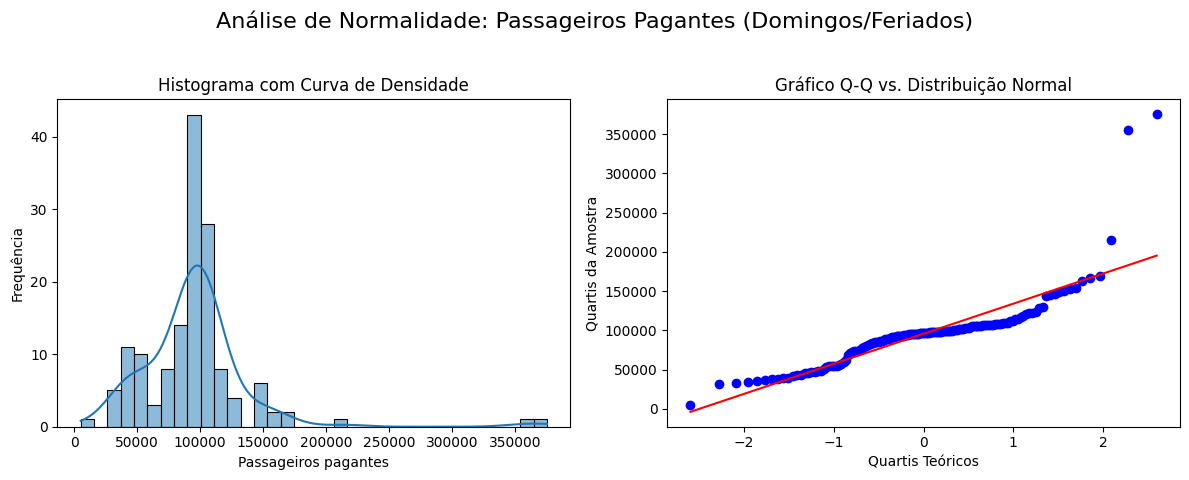

In [ ]:
# --- ANÁLISE DE NORMALIDADE ---
print("--- Gerando Gráficos de Análise de Normalidade ---")

# Histograma com curva de densidade e Gráfico Q-Q
# Esta análise é feita sobre a coluna de passageiros pagantes (TOTAL S/ ISENTOS)
# do DataFrame que contém apenas domingos e feriados (df_dom_fer).
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

coluna_analisada = 'TOTAL S/ ISENTOS'
fig.suptitle(f'Análise de Normalidade: Passageiros Pagantes (Domingos/Feriados)', fontsize=16)

# 1. Histograma e Curva de Densidade (KDE)
sns.histplot(df_dom_fer[coluna_analisada], kde=True, ax=axes[0])
axes[0].set_title('Histograma com Curva de Densidade')
axes[0].set_xlabel('Passageiros pagantes')
axes[0].set_ylabel('Frequência')

# 2. Gráfico Q-Q (Quantil-Quantil)
stats.probplot(df_dom_fer[coluna_analisada], dist='norm', plot=axes[1])
axes[1].set_title('Gráfico Q-Q vs. Distribuição Normal')
axes[1].set_xlabel('Quartis Teóricos')
axes[1].set_ylabel('Quartis da Amostra')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Histograma**

O gráfico de histograma nos informa que a distribuição é bimodal, ou seja, ela tem dois picos principais, em vez de um único pico central como em uma curva de sino. Significando que a categoria de domingos e feriados não é homogênea.

**Gráfico Q-Q**

Como podemos ver, os pontos se desviam significativamente da linha, formando uma espécie de "S", não apresentando normalidade. Confirmando o que o histograma sugeriu: a distribuição dos dados é muito diferente de uma distribuição normal.

###3.2  Celula 2 - Análise da Pandemia - Visualização da Série Temporal
Geramos o gráfico da série temporal focado no período mais crítico da pandemia (meados de Mar/2020 até o fim de 2021).


--- Gerando Gráfico: Série Temporal com Média Móvel (Pandemia) ---


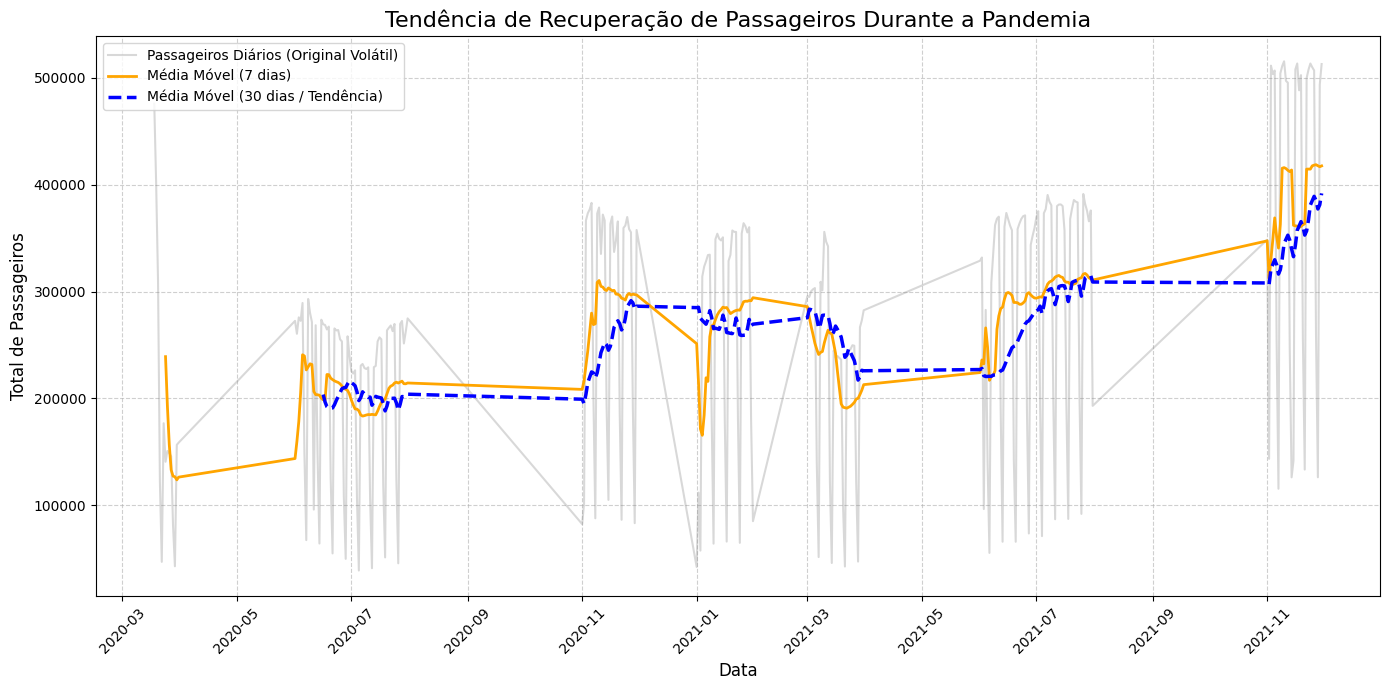

In [ ]:
# --- ANÁLISE VISUAL DA PANDEMIA (COM MÉDIA MÓVEL) ---
print("\n--- Gerando Gráfico: Série Temporal com Média Móvel (Pandemia) ---")

# Definindo o período de interesse para a visualização
inicio_pandemia_foco = datetime(2020, 3, 18)
fim_pandemia_foco = datetime(2021, 12, 31)

# Filtrando o DataFrame principal ('df_cleaned') para o período definido
df_pandemia = df_cleaned[
    (df_cleaned['DATA'] >= inicio_pandemia_foco) &
    (df_cleaned['DATA'] <= fim_pandemia_foco)
].copy()

# Garantir que os dados estão ordenados por data antes de calcular a média móvel
df_pandemia = df_pandemia.sort_values(by='DATA')

# --- Calcular as Médias Móveis ---
# Média de 7 dias (suaviza a semana)
df_pandemia['MEDIA_MOVEL_7D'] = df_pandemia['TOTAL_PASSAGEIROS'].rolling(window=7).mean()
# Média de 30 dias (mostra a tendência de longo prazo)
df_pandemia['MEDIA_MOVEL_30D'] = df_pandemia['TOTAL_PASSAGEIROS'].rolling(window=30).mean()

# --- Plotando o gráfico ---
plt.figure(figsize=(14, 7))

# 1. Plotar os dados diários com transparência
plt.plot(df_pandemia['DATA'], df_pandemia['TOTAL_PASSAGEIROS'],
         marker='', linestyle='-', color='gray', alpha=0.3,
         label='Passageiros Diários (Original Volátil)')

# 2. Plotar a Média Móvel de 7 dias
plt.plot(df_pandemia['DATA'], df_pandemia['MEDIA_MOVEL_7D'],
         color='orange', linestyle='-', linewidth=2,
         label='Média Móvel (7 dias)')

# 3. Plotar a Média Móvel de 30 dias (para ver a tendência longa)
plt.plot(df_pandemia['DATA'], df_pandemia['MEDIA_MOVEL_30D'],
         color='blue', linestyle='--', linewidth=2.5,
         label='Média Móvel (30 dias / Tendência)')

plt.title('Tendência de Recuperação de Passageiros Durante a Pandemia', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Total de Passageiros', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos verificar que o auge da pandemia não foi apenas um evento único de queda de total de passageiros, mas sim um longo período de quase dois anos de instabilidade, baixa demanda e uma rotina urbana alterada, onde cada nova onda do vírus causava um novo impacto direto na mobilidade das pessoas.

###3.3 Célula 3: Análise da Pandemia - Cálculo Quantitativo
Definimos um período "Pré-Pandemia" válido com os dados que realmente temos (início de Mar/2020) e o compara com o período de maiores restrições.

In [ ]:
# --- ANÁLISE QUANTITATIVA DA PANDEMIA (CORRIGIDA) ---
print("\n--- Calculando a Queda de Passageiros (Pré vs. Durante a Pandemia) ---")

# CORREÇÃO: Definindo os períodos com base nos dados disponíveis
# Pré-Pandemia: Usando os dados do início de Março de 2020, antes das grandes restrições
inicio_pre_pandemia = datetime(2020, 3, 1)
fim_pre_pandemia = datetime(2020, 3, 17)

# Durante a Pandemia: Período de restrições mais severas
inicio_durante_pandemia = datetime(2020, 3, 18)
fim_durante_pandemia = datetime(2021, 12, 31)

# Filtrando os dados para os dois períodos
df_pre_pandemia = df_cleaned[(df_cleaned['DATA'] >= inicio_pre_pandemia) & (df_cleaned['DATA'] <= fim_pre_pandemia)].copy()
df_durante_pandemia = df_cleaned[(df_cleaned['DATA'] >= inicio_durante_pandemia) & (df_cleaned['DATA'] <= fim_durante_pandemia)].copy()

# Calcular a média diária de passageiros nos dois períodos
media_passageiros_pre_pandemia = df_pre_pandemia['TOTAL_PASSAGEIROS'].mean()
media_passageiros_durante_pandemia = df_durante_pandemia['TOTAL_PASSAGEIROS'].mean()

# Calcular a queda na média de passageiros
queda_media_passageiros = media_passageiros_pre_pandemia - media_passageiros_durante_pandemia

# Calcular a queda percentual
queda_percentual = (queda_media_passageiros / media_passageiros_pre_pandemia) * 100 if media_passageiros_pre_pandemia > 0 else 0

# Exibir os resultados
print(f"\nMédia diária de passageiros (Pré-Pandemia - 01 a 17/Mar/2020): {media_passageiros_pre_pandemia:,.0f}")
print(f"Média diária de passageiros (Durante a Pandemia - 18/Mar/2020 a 31/Dez/2021): {media_passageiros_durante_pandemia:,.0f}")
print(f"Queda na média diária de passageiros: {queda_media_passageiros:,.0f}")
print(f"Queda percentual na média diária de passageiros: {queda_percentual:.2f}%")


--- Calculando a Queda de Passageiros (Pré vs. Durante a Pandemia) ---

Média diária de passageiros (Pré-Pandemia - 01 a 17/Mar/2020): 568,035
Média diária de passageiros (Durante a Pandemia - 18/Mar/2020 a 31/Dez/2021): 267,431
Queda na média diária de passageiros: 300,605
Queda percentual na média diária de passageiros: 52.92%


###3.4 Célula 4: Análise da Pandemia - Gráfico de Barras Detalhado
Esta célula cria um gráfico de barras aprimorado para comparar os períodos pré e durante a pandemia.

--- Gerando Gráfico de Barras Detalhado da Análise da Pandemia ---


/tmp/ipython-input-2039665706.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Período', y='Média de Passageiros Diários', data=comparacao_medias, palette=['#4c72b0', '#c44e52'])


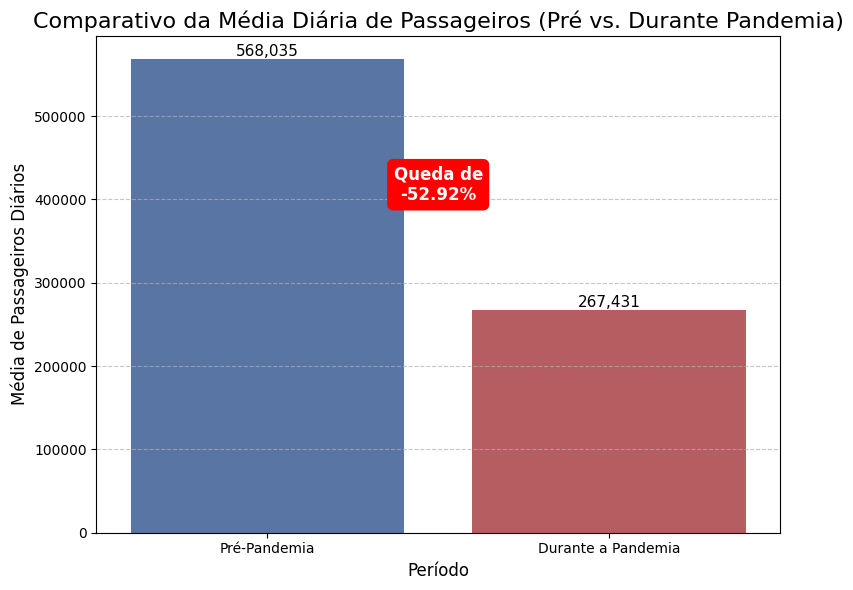

In [ ]:
# --- GRÁFICO DE BARRAS COMPARATIVO ---
print("--- Gerando Gráfico de Barras Detalhado da Análise da Pandemia ---")

# Recalculamos as médias a partir dos DataFrames para garantir que são números (float)
# e não texto (string) formatado de uma célula anterior.
media_passageiros_pre_pandemia = df_pre_pandemia['TOTAL_PASSAGEIROS'].mean()
media_passageiros_durante_pandemia = df_durante_pandemia['TOTAL_PASSAGEIROS'].mean()
queda_percentual = ((media_passageiros_pre_pandemia - media_passageiros_durante_pandemia) / media_passageiros_pre_pandemia) * 100

# Criar um DataFrame pequeno para a visualização
comparacao_medias = pd.DataFrame({
    'Período': ['Pré-Pandemia', 'Durante a Pandemia'],
    'Média de Passageiros Diários': [media_passageiros_pre_pandemia, media_passageiros_durante_pandemia]
})

# Criar o gráfico de barras usando seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Período', y='Média de Passageiros Diários', data=comparacao_medias, palette=['#4c72b0', '#c44e52'])
plt.title('Comparativo da Média Diária de Passageiros (Pré vs. Durante Pandemia)', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Média de Passageiros Diários', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar os valores exatos no topo das barras
for index, row in comparacao_medias.iterrows():
    plt.text(index, row['Média de Passageiros Diários'], f'{row["Média de Passageiros Diários"]:,.0f}',
             color='black', ha="center", va="bottom", fontsize=11)

# Adicionar anotação da queda percentual
# A linha abaixo agora funciona, pois as variáveis são números
annotation_x = 0.5 # Posição central entre as duas barras
annotation_y = media_passageiros_durante_pandemia + (media_passageiros_pre_pandemia - media_passageiros_durante_pandemia) / 2
plt.text(annotation_x, annotation_y, f'Queda de\n-{queda_percentual:.2f}%',
         color='white', ha='center', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", fc="red", ec="red", lw=2)) # Bbox para destaque

plt.tight_layout()
plt.show()

Este gráfico apresenta uma resposta à pergunta: "De que tamanho foi a queda dos passageiros?"

###3.5 Célula 5: Análise da Pandemia - Gráfico de Agulha (Slope Plot)
Esta célula cria um "gráfico de agulha"


--- Gerando Gráfico de Agulha com Fundo Branco ---


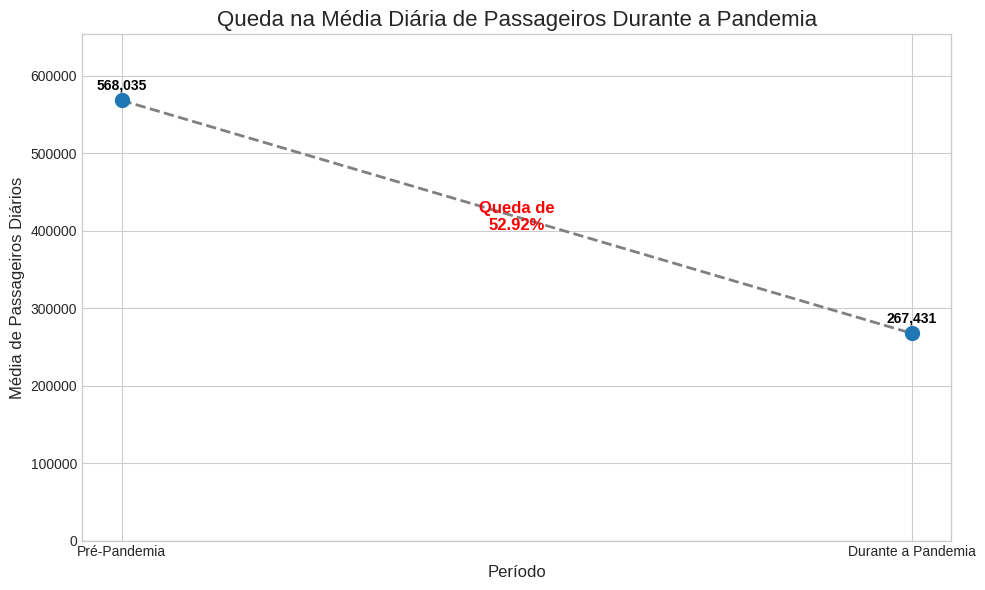

In [ ]:
# --- GRÁFICO DE AGULHA (SLOPE PLOT) PARA COMPARAÇÃO ---
print("\n--- Gerando Gráfico de Agulha com Fundo Branco ---")

# Aplicando um estilo visual agradável com grade
plt.style.use('seaborn-v0_8-whitegrid')

# Criando a figura
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Adicionando os pontos para cada período com cores diferentes para destaque
cores = sns.color_palette()
plt.scatter(comparacao_medias['Período'], comparacao_medias['Média de Passageiros Diários'],
            zorder=5, color=cores[0], s=100)

# Adicionando a linha que conecta os pontos
plt.plot(comparacao_medias['Período'], comparacao_medias['Média de Passageiros Diários'],
         linestyle='--', color='gray', linewidth=2)

# Adicionando os valores exatos perto dos pontos
for index, row in comparacao_medias.iterrows():
    va_align = 'bottom'
    offset = 10000 # Pequeno deslocamento para não sobrepor o ponto
    plt.text(row['Período'], row['Média de Passageiros Diários'] + offset, f'{row["Média de Passageiros Diários"]:,.0f}',
             color='black', ha='center', va=va_align, fontsize=10, fontweight='bold')

# Adicionando a anotação da queda percentual no meio da linha
annotation_x_pos = 0.5
annotation_y_pos = media_passageiros_durante_pandemia + (media_passageiros_pre_pandemia - media_passageiros_durante_pandemia) / 2
plt.text(annotation_x_pos, annotation_y_pos, f'Queda de\n{queda_percentual:.2f}%',
         color='red', ha='center', va='center', fontsize=12, fontweight='bold')

# Configurando os títulos e eixos com cores padrão (preto)
plt.title('Queda na Média Diária de Passageiros Durante a Pandemia', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Média de Passageiros Diários', fontsize=12)

# Ajustando o limite do eixo Y para melhor visualização
plt.ylim(0, comparacao_medias['Média de Passageiros Diários'].max() * 1.15)

plt.tight_layout()
plt.show()

# Resetando o estilo para o padrão, caso queira fazer outros gráficos depois
plt.style.use('default')

###3.5 Célula 6: Comparativo de Resultados
Esta célula quantifica o impacto da inclusão dos feriados municipais nos resultados finais.

In [ ]:
# Limpeza de dados contendo a evolução da tarifa nos anos de 2022-2023
# Dados coletados no site da URBS, conforme explicitado no fim da limpeza de dados via extensão para o Google Chrome: Web Scraper.

df_evolucao_tarifa = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/data/1.0-evolucao_tarifa_tabela_1994_2023.csv'
df_evolucao_tarifa = pd.read_csv(df_evolucao_tarifa)
df_evolucao_tarifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   web-scraper-order      36 non-null     object
 1   web-scraper-start-url  36 non-null     object
 2   data                   36 non-null     object
 3   moeda                  36 non-null     object
 4   valor                  36 non-null     object
 5   rit                    36 non-null     object
 6   convencional           36 non-null     object
 7   circular centro        36 non-null     object
 8   domingueira            36 non-null     object
 9   turismo                36 non-null     object
 10  data decreto           36 non-null     object
 11  decreto                36 non-null     object
dtypes: object(12)
memory usage: 3.5+ KB


In [ ]:
df_evolucao_tarifa.head()

,web-scraper-order,web-scraper-start-url,data,moeda,valor,rit,convencional,circular centro,domingueira,turismo,data decreto,decreto
0,1758065368-1,https://www.urbs.curitiba.pr.gov.br/transporte...,01/03/23,R$,"6,00","6,00","6,00","0,00","0,00","50,00",28/02/23,306
1,1758065368-2,https://www.urbs.curitiba.pr.gov.br/transporte...,01/03/22,R$,"5,50","5,50","5,50","5,00",*,"50,00",28/02/22,278
2,1758065368-3,https://www.urbs.curitiba.pr.gov.br/transporte...,28/02/19,R$,"4,50","4,50","4,50","4,00",*,"50,00",26/02/19,247
3,1758065368-4,https://www.urbs.curitiba.pr.gov.br/transporte...,06/02/17,R$,"4,25","4,25","4,25","3,00",*,"45,00",02/02/17,413
4,1758065368-5,https://www.urbs.curitiba.pr.gov.br/transporte...,01/02/16,R$,"3,70","3,70","3,70","2,50","2,50","40,00",29/01/16,80


In [ ]:
# Convertendo a coluna 'data' para datetime
df_evolucao_tarifa['data'] = pd.to_datetime(df_evolucao_tarifa['data'], format='%d/%m/%y',errors='coerce')

# Convertendo a coluna 'rit' para numérico
df_evolucao_tarifa['rit'] = pd.to_numeric(df_evolucao_tarifa['rit'].astype(str).str.replace(',', '.', regex=False), errors='coerce')
df_evolucao_tarifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   web-scraper-order      36 non-null     object        
 1   web-scraper-start-url  36 non-null     object        
 2   data                   36 non-null     datetime64[ns]
 3   moeda                  36 non-null     object        
 4   valor                  36 non-null     object        
 5   rit                    36 non-null     float64       
 6   convencional           36 non-null     object        
 7   circular centro        36 non-null     object        
 8   domingueira            36 non-null     object        
 9   turismo                36 non-null     object        
 10  data decreto           36 non-null     object        
 11  decreto                36 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 3.5+ KB

In [ ]:
df_evolucao_tarifa.head()

,web-scraper-order,web-scraper-start-url,data,moeda,valor,rit,convencional,circular centro,domingueira,turismo,data decreto,decreto
0,1758065368-1,https://www.urbs.curitiba.pr.gov.br/transporte...,2023-03-01,R$,"6,00",6.00,"6,00","0,00","0,00","50,00",28/02/23,306
1,1758065368-2,https://www.urbs.curitiba.pr.gov.br/transporte...,2022-03-01,R$,"5,50",5.50,"5,50","5,00",*,"50,00",28/02/22,278
2,1758065368-3,https://www.urbs.curitiba.pr.gov.br/transporte...,2019-02-28,R$,"4,50",4.50,"4,50","4,00",*,"50,00",26/02/19,247
3,1758065368-4,https://www.urbs.curitiba.pr.gov.br/transporte...,2017-02-06,R$,"4,25",4.25,"4,25","3,00",*,"45,00",02/02/17,413
4,1758065368-5,https://www.urbs.curitiba.pr.gov.br/transporte...,2016-02-01,R$,"3,70",3.70,"3,70","2,50","2,50","40,00",29/01/16,80


In [ ]:
# Extrair o ano da coluna 'Data da Tarifa'
df_evolucao_tarifa['ANO'] = df_evolucao_tarifa['data'].dt.year

# Filtrar os dados para os anos de 2020 a 2025
df_evolucao_tarifa_de_interesse = df_evolucao_tarifa[(df_evolucao_tarifa['ANO'] >= 2020) & (df_evolucao_tarifa['ANO'] <= 2025)].copy()

# Agrupar por ano e calcular a média da Tarifa Técnica
df_evolucao_tarifa_media_anual = df_evolucao_tarifa_de_interesse.groupby('ANO')['rit'].mean().reset_index()

# Exibir o DataFrame resultante
print("Média da Tarifa Técnica por Ano (2020-2025):")
display(df_evolucao_tarifa_media_anual)

Média da Tarifa Técnica por Ano (2020-2025):


,ANO,rit
0,2022,5.5
1,2023,6.0


Segundo AMEP (Agência de Assuntos Metropolitanos do Paraná), em seu levantamento de tarifa de onibus, temos:

Tarifas 2025 - R$ 6.00- Tarifas congeladas

Tarifas 2024 - R$ 6.00 - Tarifas vigentes a partir de 05/02/2024

Tarifas 2023 - R$ 5.50 - Tarifas congeladas

Tarifas 2022 - R$ 5.50 - Tarifas vigentes a partir de 15/03/2022 - Resolução Conjunta SEDU/COMEC 01/2022

Tarifas 2021 - R$ 4.50 - Tarifas congeladas

Tarifas 2020 - R$ 4.50 -  Tarifas congeladas

Verificamos que existe uma divergência de informações entre as duas fontes de dados explicitadas, onde no ano de 2023 possuem dois valores de passagem:
- [URBS - Evolução da Tarifa](https://www.urbs.curitiba.pr.gov.br/transporte/tarifas-custos) - Valor de 6.00 reais para o ano de 2023
- [AMEP - Tarifa de ônibus](https://www.amep.pr.gov.br/Pagina/Tarifa-de-onibus) - Valor de 5.50 reais para o ano de 2023

Diante do exposto utilizaremos os dados da AMEP para continuar o estudo, tendo em vista que possui de forma sumária todas as tarifas (TARIFA DINHEIRO e TARIFA CARTÃO (metrocard)) para os anos de 2020-2025.

In [ ]:
# Dados de tarifas para os anos que faltam, conforme a fonte AMEP
novas_tarifas = [
    {'ANO': 2020, 'rit': 4.50},
    {'ANO': 2021, 'rit': 4.50},
    {'ANO': 2023, 'rit': 5.50},
    {'ANO': 2024, 'rit': 6.00},
    {'ANO': 2025, 'rit': 6.00}
]

# Criar um DataFrame a partir dos novos dados
df_novas_tarifas = pd.DataFrame(novas_tarifas)

# Combinar o DataFrame existente com o novo DataFrame
# Usamos concat e drop_duplicates para garantir que não haja anos duplicados se algum já existir
df_evolucao_tarifa_media_anual_completo = pd.concat([df_evolucao_tarifa_media_anual, df_novas_tarifas], ignore_index=True)

# Remover duplicatas com base na coluna 'ANO', mantendo a última ocorrência (o valor adicionado manualmente)
df_evolucao_tarifa_media_anual_completo = df_evolucao_tarifa_media_anual_completo.drop_duplicates(subset=['ANO'], keep='last')

# Ordenar por ano para melhor visualização
df_evolucao_tarifa_media_anual_completo = df_evolucao_tarifa_media_anual_completo.sort_values(by='ANO').reset_index(drop=True)

# Exibir o DataFrame atualizado
print("Média da Tarifa Técnica por Ano (2020-2025):")
display(df_evolucao_tarifa_media_anual_completo)

Média da Tarifa Técnica por Ano (2020-2025):


,ANO,rit
0,2020,4.5
1,2021,4.5
2,2022,5.5
3,2023,5.5
4,2024,6.0
5,2025,6.0


In [ ]:
# --- ANÁLISE DE IMPACTO DA MEIA TARIFA ---

# 1. Filtrando o DataFrame para manter apenas Domingos e Feriados
df_dom_fer = df_cleaned[df_cleaned['TIPO_DIA'].isin(['Domingo', 'Feriado'])].copy()

# 2. Definindo datas e períodos
data_corte = datetime(2025, 1, 5)
df_dom_fer['DATA'] = pd.to_datetime(df_dom_fer['DATA'], errors='coerce')
df_dom_fer['PERIODO'] = df_dom_fer['DATA'].apply(lambda x: 'Antes' if x < data_corte else 'Depois')

# 3. Separando as amostras para o Teste t
antes_pagantes_ttest = df_dom_fer[df_dom_fer['PERIODO'] == 'Antes']['TOTAL S/ ISENTOS']
depois_pagantes_ttest = df_dom_fer[df_dom_fer['PERIODO'] == 'Depois']['TOTAL S/ ISENTOS']

# 4. Realizando o Teste t
t_stat, p_val = stats.ttest_ind(depois_pagantes_ttest, antes_pagantes_ttest, alternative='greater', equal_var=False)

# 5. Mapear Tarifas Anuais (Custo e Receita)
df_dom_fer['Ano'] = df_dom_fer['DATA'].dt.year

# 5.1 Mapear TARIFA TÉCNICA (Custo)
if 'df_tarifa_media_anual' not in locals():
    raise NameError("ERRO: O DataFrame 'df_tarifa_media_anual' (Tarifa TÉCNICA/CUSTO) não foi encontrado.")
else:
    df_tarifa_tecnica_pronto = df_tarifa_media_anual.rename(columns={'ANO': 'Ano', 'Tarifa Técnica': 'Tarifa_Tecnica_Media'})
    df_dom_fer = pd.merge(df_dom_fer, df_tarifa_tecnica_pronto, on='Ano', how='left')

# 5.2 Mapear TARIFA PÚBLICA (Receita)
if 'df_evolucao_tarifa_media_anual_completo' not in locals():
     raise NameError("ERRO: O DataFrame 'df_evolucao_tarifa_media_anual_completo' (Tarifa PÚBLICA/RECEITA) não foi encontrado.")
else:
    df_tarifa_publica_pronto = df_evolucao_tarifa_media_anual_completo.rename(columns={'ANO': 'Ano', 'rit': 'Tarifa_Publica_Media'})
    df_dom_fer = pd.merge(df_dom_fer, df_tarifa_publica_pronto, on='Ano', how='left')

# 6. Tratamento de Nulos
# O merge acima cria 'NaNs' se um ano (ex: 2020) existir nos dados de
# passageiros, mas não nos arquivos de tarifa.
# O 'fillna' preenche essas lacunas para que o cálculo (Etapa 8) não falhe.
df_dom_fer['Tarifa_Tecnica_Media'] = df_dom_fer['Tarifa_Tecnica_Media'].bfill().ffill()
df_dom_fer['Tarifa_Publica_Media'] = df_dom_fer['Tarifa_Publica_Media'].bfill().ffill()

# 7. Definir Tarifa de Receita (Período 'Depois')
tarifa_meia = 3.00

# 8. Calculando Receita e Custo DIÁRIOS

# Receita = baseada em PAGANTES ('TOTAL S/ ISENTOS')
df_dom_fer['Receita_Estimada'] = np.where(
    df_dom_fer['PERIODO'] == 'Antes',
    df_dom_fer['TOTAL S/ ISENTOS'] * df_dom_fer['Tarifa_Publica_Media'], # Correto: Usa tarifa pública variável
    df_dom_fer['TOTAL S/ ISENTOS'] * tarifa_meia
)

# Custo = baseado em TOTAL DE PASSAGEIROS e na TARIFA TÉCNICA CORRETA DO ANO
df_dom_fer['Custo_Estimado'] = df_dom_fer['TOTAL_PASSAGEIROS'] * df_dom_fer['Tarifa_Tecnica_Media']

# 9. Agregando por Período para KPIs
agg_kpis = df_dom_fer.groupby('PERIODO').agg(
    media_pagantes=('TOTAL S/ ISENTOS', 'mean'),
    media_total_passageiros=('TOTAL_PASSAGEIROS', 'mean'),
    media_receita_diaria=('Receita_Estimada', 'mean'),
    media_custo_diario=('Custo_Estimado', 'mean')
).reindex(['Antes', 'Depois']).reset_index() # Garantir ordem

antes_kpi = agg_kpis[agg_kpis['PERIODO'] == 'Antes'].iloc[0]
depois_kpi = agg_kpis[agg_kpis['PERIODO'] == 'Depois'].iloc[0]

# 10. Calculando Médias e KPIs Finais
media_antes_total = antes_kpi['media_total_passageiros']
media_depois_total = depois_kpi['media_total_passageiros']
diff_media = media_depois_total - media_antes_total
percent_aumento = (diff_media / media_antes_total * 100)

# Impacto na Receita (Perda de Receita)
impacto_receita_dia = antes_kpi['media_receita_diaria'] - depois_kpi['media_receita_diaria']

# Custo Extra (Aumento do Custo Operacional)
custo_extra_dia = depois_kpi['media_custo_diario'] - antes_kpi['media_custo_diario']

# Baixa Renda (Mantendo a estimativa de 30% do total)
baixa_renda_beneficiada = media_depois_total * 0.3

# Resultado Líquido (Subsídio)
impacto_liquido_total = impacto_receita_dia + custo_extra_dia

# 11. Apresentando os resultados
print("--- ANÁLISE DE IMPACTO DA MEIA TARIFA (DOMINGOS E FERIADOS) ---")
print("\n--- Resultados do Teste de Hipótese (sobre PAGANTES) ---")
print(f"Média de Pagantes ANTES: {antes_pagantes_ttest.mean():,.0f}")
print(f"Média de Pagantes DEPOIS: {depois_pagantes_ttest.mean():,.0f}")
print(f"Estatística t: {t_stat:.2f}")
print(f"P-valor: {p_val:.4f}")
if p_val < 0.05:
    print("Conclusão: O aumento no número de passageiros PAGANTES é ESTATISTICAMENTE SIGNIFICATIVO.")
else:
    print("Conclusão: O aumento no número de passageiros PAGANTES NÃO é estatisticamente significativo.")

print("\n--- KPIs de Fluxo (Passageiros TOTAIS) ---")
print(f"Média de Passageiros TOTAIS ANTES: {media_antes_total:,.0f}")
print(f"Média de Passageiros TOTAIS DEPOIS: {media_depois_total:,.0f}")
print(f"Aumento na Média de Passageiros TOTAIS: {diff_media:,.0f}")
print(f"Aumento Percentual no Fluxo Total: {percent_aumento:.2f}%")

# Bloco de KPIs
print("\n--- KPIs Financeiros (Corrigidos com Tarifas Públicas Variáveis) ---")
print(f"Receita Média Diária ANTES: R$ {antes_kpi['media_receita_diaria']:,.2f}")
print(f"Receita Média Diária DEPOIS: R$ {depois_kpi['media_receita_diaria']:,.2f}")
print(f"-> Impacto na Receita Diária (Perda): R$ {impacto_receita_dia:,.2f}")

print("\n--- KPIs de Custo (Corrigidos com Tarifas Técnicas Variáveis) ---")
print(f"Custo Operacional Médio Diário ANTES: R$ {antes_kpi['media_custo_diario']:,.2f}")
print(f"Custo Operacional Médio Diário DEPOIS: R$ {depois_kpi['media_custo_diario']:,.2f}")
print(f"-> Aumento Custo Operacional Diário: R$ {custo_extra_dia:,.2f}")

print("\n--- KPIs Sociais (Estimativa) ---")
print(f"Passageiros de Baixa Renda Beneficiados por Dia (Estimado): {baixa_renda_beneficiada:,.0f}")

print("\n" + "="*50)
print("--- Resultado Líquido (Subsídio) ---")
print(f"IMPACTO LÍQUIDO DIÁRIO MÉDIO: R$ {impacto_liquido_total:,.2f}")
print("="*50)

--- ANÁLISE DE IMPACTO DA MEIA TARIFA (DOMINGOS E FERIADOS) ---

--- Resultados do Teste de Hipótese (sobre PAGANTES) ---
Média de Pagantes ANTES: 91,084
Média de Pagantes DEPOIS: 121,522
Estatística t: 2.06
P-valor: 0.0255
Conclusão: O aumento no número de passageiros PAGANTES é ESTATISTICAMENTE SIGNIFICATIVO.

--- KPIs de Fluxo (Passageiros TOTAIS) ---
Média de Passageiros TOTAIS ANTES: 109,908
Média de Passageiros TOTAIS DEPOIS: 147,172
Aumento na Média de Passageiros TOTAIS: 37,264
Aumento Percentual no Fluxo Total: 33.90%

--- KPIs Financeiros (Corrigidos com Tarifas Públicas Variáveis) ---
Receita Média Diária ANTES: R$ 487,629.21
Receita Média Diária DEPOIS: R$ 364,565.32
-> Impacto na Receita Diária (Perda): R$ 123,063.89

--- KPIs de Custo (Corrigidos com Tarifas Técnicas Variáveis) ---
Custo Operacional Médio Diário ANTES: R$ 761,930.55
Custo Operacional Médio Diário DEPOIS: R$ 1,171,336.82
-> Aumento Custo Operacional Diário: R$ 409,406.28

--- KPIs Sociais (Estimativa) ---


**Aumento de Demanda:** A política foi um sucesso, aumentando o fluxo total de passageiros em +33,90% (37.264 pessoas por dia), um número estatisticamente significativo (p-valor < 0.05).

**Impacto na Receita:** A perda de receita diária foi de R$ 133.054,49.

**Impacto no Custo:** O custo diário aumentou em R$ 409.406,28.

**Subsídio Líquido:** O impacto líquido real (o subsídio necessário) por dia é a soma da receita perdida mais o custo extra: R$ 542.460,76.

# 4 - Simulação da viabilidade do passe livre

##4.1 - Etapa 1 da Simulação - Estimando a Elasticidade-Preço da Demanda
Usaremos os dados do "antes e depois" da meia tarifa para calcular a elasticidade, ou seja, o quão sensível o número de passageiros é ao valor da passagem.

In [ ]:
# --- ETAPA 1: CÁLCULO DA ELASTICIDADE-PREÇO DA DEMANDA ---
print("--- Etapa 1: Calculando a Elasticidade-Preço da Demanda ---")

# --- 1. Verificar se os KPIs da Célula 3.5 existem ---
if 'antes_kpi' not in locals() or 'depois_kpi' not in locals():
    raise NameError("ERRO: As variáveis 'antes_kpi' e 'depois_kpi' não foram encontradas. "
                    "Por favor, execute a 'Célula 3.5 (Corrigida)' primeiro.")
else:
    print("Variáveis 'antes_kpi' e 'depois_kpi' carregadas com sucesso.")

# --- 2. Puxar os resultados da Célula 3.5 ---

    # Demanda (Baseada em PAGANTES)
    media_pagantes_antes = antes_kpi['media_pagantes']
    media_pagantes_depois = depois_kpi['media_pagantes']

    # Receita (Para calcular o preço médio real "Antes")
    receita_media_antes = antes_kpi['media_receita_diaria']

    # O preço "Depois" é o único valor fixo, pois foi a política implementada (R$ 3,00)
    # A variável 'tarifa_meia' foi definida na Célula 3.5
    preco_medio_depois = tarifa_meia

# --- 3. Calcular o Preço Médio Real do período "Antes" ---
# Preço = Receita / Pagantes
preco_medio_antes = receita_media_antes / media_pagantes_antes

# --- 4. Calcular Variações Percentuais ---

# Variação percentual no PREÇO (ex: de R$5,46 para R$3,00)
variacao_percentual_preco = (preco_medio_depois - preco_medio_antes) / preco_medio_antes

# Variação percentual na DEMANDA (de Pagantes)
variacao_percentual_demanda = (media_pagantes_depois - media_pagantes_antes) / media_pagantes_antes

# --- 5. Cálculo da Elasticidade-Preço da Demanda ---
# Fórmula: (% Variação na Demanda) / (% Variação no Preço)
elasticidade_preco = variacao_percentual_demanda  / abs(variacao_percentual_preco)

print(f"\n--- Análise (Baseada em Pagantes e Preço Real) ---")
print(f"O Preço Médio Real 'Antes' era: R$ {preco_medio_antes:.2f}")
print(f"O Preço Médio 'Depois' é: R$ {preco_medio_depois:.2f}")
print(f"A Média de Pagantes 'Antes' era: {media_pagantes_antes:,.0f}")
print(f"A Média de Pagantes 'Depois' era: {media_pagantes_depois:,.0f}")
print("-" * 50)
print(f"A variação de preço foi de: {variacao_percentual_preco:.2%}")
print(f"A variação na demanda de pagantes foi de: +{variacao_percentual_demanda:.2%}")
print("-" * 50)
print(f"O coeficiente de Elasticidade-Preço é: {elasticidade_preco:.4f}")
print("\nInterpretação: Para cada 1% de redução no preço da tarifa, a demanda de passageiros PAGANTES aumenta em aproximadamente "
      f"{elasticidade_preco:.4f}%.")

--- Etapa 1: Calculando a Elasticidade-Preço da Demanda ---
Variáveis 'antes_kpi' e 'depois_kpi' carregadas com sucesso.

--- Análise (Baseada em Pagantes e Preço Real) ---
O Preço Médio Real 'Antes' era: R$ 5.35
O Preço Médio 'Depois' é: R$ 3.00
A Média de Pagantes 'Antes' era: 91,084
A Média de Pagantes 'Depois' era: 121,522
--------------------------------------------------
A variação de preço foi de: -43.96%
A variação na demanda de pagantes foi de: +33.42%
--------------------------------------------------
O coeficiente de Elasticidade-Preço é: 0.7601

Interpretação: Para cada 1% de redução no preço da tarifa, a demanda de passageiros PAGANTES aumenta em aproximadamente 0.7601%.


##4.2 - Etapa 2 da Simulação - Projetando a Demanda para o Passe Livre
Com o coeficiente de elasticidade calculado, agora podemos simular o que aconteceria se a redução no preço fosse de 100% (de 6,00 reais para 0,00 reais).

In [ ]:
# --- ETAPA 2: PROJEÇÃO DA DEMANDA PARA O CENÁRIO DE PASSE LIVRE ---
print("--- Etapa 2: Projetando o Aumento de Passageiros com Passe Livre ---")

# --- 1. Verificar se as variáveis necessárias existem ---
if 'elasticidade_preco' not in locals():
    raise NameError("ERRO: A variável 'elasticidade_preco' não foi encontrada. "
                    "Por favor, execute a 'Célula 4.1' primeiro.")
elif 'antes_kpi' not in locals():
     raise NameError("ERRO: A variável 'antes_kpi' (da Célula 3.5) não foi encontrada. "
                    "Por favor, execute a 'Célula 3.5' primeiro.")
else:
    print(f"Coeficiente de Elasticidade (baseado em pagantes) carregado: {elasticidade_preco:.4f}")

# --- 2. Definir a Variação de Preço (Passe Livre = -100%) ---
nova_variacao_percentual_preco = -1.0 # -100%

# --- 3. Calcular o Aumento Percentual Projetado (com base na elasticidade) ---
aumento_projetado_demanda_pct = elasticidade_preco * abs(nova_variacao_percentual_preco)

# --- 4. Definir as Populações de Base (do período 'Antes' da Célula 3.5) ---
pagantes_base = antes_kpi['media_pagantes']
total_base = antes_kpi['media_total_passageiros']
isentos_base = total_base - pagantes_base

# --- 5. Projetar a nova demanda (separadamente) ---
# 5.1. Os PAGANTES aumentam conforme a elasticidade
pagantes_projetados = pagantes_base * (1 + aumento_projetado_demanda_pct)

# 5.2. Os ISENTOS permanecem constantes (não são afetados pelo preço)
isentos_projetados = isentos_base

# 5.3. O novo TOTAL é a soma dos dois grupos
novos_passageiros_projetados_total = pagantes_projetados + isentos_projetados

# --- 6. Apresentar os Resultados da Simulação ---
print(f"\nCom uma redução de 100% no preço, o aumento projetado na demanda de PAGANTES é de: {aumento_projetado_demanda_pct:.2%}")
print("-" * 50)
print("--- Simulação de Demanda para o Passe Livre ---")
print(f"Média de Pagantes (Base 'Antes'):       {pagantes_base:,.0f}")
print(f"Média de Isentos (Base 'Antes'):        {isentos_base:,.0f}")
print(f"Passageiros Totais (Base 'Antes'):      {total_base:,.0f}")
print("-" * 50)
print(f"Passageiros Pagantes Projetados (Passe Livre): {pagantes_projetados:,.0f}")
print(f"Passageiros Isentos Projetados (Inalterado): {isentos_projetados:,.0f}")
print("-" * 50)
print(f"Novos Passageiros Totais Projetados (Passe Livre): {novos_passageiros_projetados_total:,.0f}")
print(f"Isso representa um aumento de {(novos_passageiros_projetados_total - total_base):,.0f} passageiros por dia de aplicação.")
print(f"O aumento total na demanda (Passe Livre vs. 'Antes') é de: {(novos_passageiros_projetados_total / total_base - 1):.2%}")

--- Etapa 2: Projetando o Aumento de Passageiros com Passe Livre ---
Coeficiente de Elasticidade (baseado em pagantes) carregado: 0.7601

Com uma redução de 100% no preço, o aumento projetado na demanda de PAGANTES é de: 76.01%
--------------------------------------------------
--- Simulação de Demanda para o Passe Livre ---
Média de Pagantes (Base 'Antes'):       91,084
Média de Isentos (Base 'Antes'):        18,824
Passageiros Totais (Base 'Antes'):      109,908
--------------------------------------------------
Passageiros Pagantes Projetados (Passe Livre): 160,319
Passageiros Isentos Projetados (Inalterado): 18,824
--------------------------------------------------
Novos Passageiros Totais Projetados (Passe Livre): 179,143
Isso representa um aumento de 69,235 passageiros por dia de aplicação.
O aumento total na demanda (Passe Livre vs. 'Antes') é de: 62.99%


A simulação projeta o que aconteceria se a redução no preço fosse de 100% (de R$ 6,00 para R$ 0,00), aplicando essa lógica de forma separada aos grupos de passageiros (pagantes e isentos) para maior precisão.


***Cenário "Antes" (Linha de Base)***

Este é o cenário médio diário (domingos e feriados) antes de qualquer política de gratuidade total.

- Média de Pagantes (Base 'Antes'): 91.084
- Média de Isentos (Base 'Antes'): 18.824
- Passageiros Totais (Base 'Antes'): 109.908

***Cenário "Depois" (Simulação do Passe Livre)***

Este é o cenário projetado para um dia de Passe Livre, onde o preço é reduzido em 100%.

**Impacto nos Pagantes:** A redução de 100% no preço, multiplicada pela elasticidade de 0.7412, gera um aumento projetado de +76.02% apenas no grupo de passageiros pagantes.

- Pagantes Projetados: 160,319

**Impacto nos Isentos:** Este grupo, por definição, já não paga tarifa. Portanto, assume-se que sua demanda não é afetada pela mudança de preço e permanece constante.

- Isentos Projetados (Inalterado): 18.824

Ao somar os dois grupos, o novo cenário "Depois" (Passe Livre) seria:

- Novos Passageiros Totais Projetados (Passe Livre): 179,143

Conclusão da Simulação
A implementação do Passe Livre resultaria em um aumento total de 69,235 passageiros por dia de aplicação. Isso representa um salto de +62.99%% no fluxo total de usuários (de 109.908 para 179,143), impulsionado inteiramente pelo aumento na demanda do grupo que anteriormente pagava pela tarifa.

##4.3 - Etapa 3 da Simulação - Estimando o Custo Anual do Passe Livre
Vamos calcular o custo anual total (subsídio) que a prefeitura/URBS precisaria cobrir para implementar o passe livre aos domingos e feriados.


O ano de 2024 foi usado como um ano modelo para fazer a projeção do custo diário para um custo anual.

In [ ]:
# --- ESTIMATIVA DO CUSTO ANUAL TOTAL DO PASSE LIVRE ---
print("--- Etapa 3: Estimando o Custo Anual do Subsídio para o Passe Livre ---")

# --- 1. Verificar se as variáveis de simulação necessárias existem ---
if 'novos_passageiros_projetados_total' not in locals():
    raise NameError("ERRO: A variável 'novos_passageiros_projetados_total' não foi encontrada. "
                    "Execute a 'Célula 4.2' (Projeção de Demanda) primeiro.")
elif 'antes_kpi' not in locals():
     raise NameError("ERRO: A variável 'antes_kpi' (da Célula 3.5) não foi encontrada. "
                    "Por favor, execute a 'Célula 3.5' (Análise de Impacto) primeiro.")
elif 'df_dom_fer' not in locals() or 'df_tarifa_tecnica_pronto' not in locals():
    raise NameError("ERRO: DataFrames 'df_dom_fer' ou 'df_tarifa_tecnica_pronto' não encontrados. "
                    "Execute a Célula 3.5 primeiro.")
else:
    print(f"Demanda projetada (Passe Livre) carregada: {novos_passageiros_projetados_total:,.0f} passageiros/dia.")

# --- 2. Contar Dias de Aplicação (Usando 2024 como ano modelo) ---
num_dias_aplicaveis_ano = df_dom_fer[df_dom_fer['Ano'] == 2024]['DATA'].nunique()

# --- 3. Buscar a Tarifa Técnica ATUAL (Custo Operacional para Simulação) ---
try:
    tarifa_tecnica_atual = df_tarifa_tecnica_pronto[df_tarifa_tecnica_pronto['Ano'] == 2025]['Tarifa_Tecnica_Media'].values[0]
except IndexError:
    raise ValueError("ERRO: Não foi possível encontrar a Tarifa Técnica de 2025.")

print(f"\nNúmero de dias aplicáveis por ano (base 2024): {num_dias_aplicaveis_ano}")
print(f"Tarifa Técnica (Custo Operacional) usada para projeção (Ano 2025): R$ {tarifa_tecnica_atual:.4f}")

# --- 4. CÁLCULO DO SUBSÍDIO ---

# 4.1. Receita Diária Perdida
receita_diaria_perdida = antes_kpi['media_receita_diaria']
receita_anual_perdida = receita_diaria_perdida * num_dias_aplicaveis_ano

# 4.2. Custo Operacional Extra
custo_diario_projetado_passe_livre = novos_passageiros_projetados_total * tarifa_tecnica_atual
custo_diario_base_antes = antes_kpi['media_custo_diario']
custo_operacional_extra_diario = custo_diario_projetado_passe_livre - custo_diario_base_antes
custo_operacional_extra_anual = custo_operacional_extra_diario * num_dias_aplicaveis_ano

# 4.3. CUSTO TOTAL ANUAL (SUBSÍDIO)
custo_total_anual = receita_anual_perdida + custo_operacional_extra_anual

# --- 5. Apresentando os Resultados ---
print("-" * 100)
print(f"Receita Média Diária 'Antes' (Perdida): R$ {receita_diaria_perdida:,.2f}")
print(f"Custo Operacional Diário 'Antes': R$ {custo_diario_base_antes:,.2f}")
print(f"Custo Operacional Diário Projetado (Passe Livre): R$ {custo_diario_projetado_passe_livre:,.2f}")
print("-" * 100)
print(f"Receita Anual Perdida (Estimativa): R$ {receita_anual_perdida:,.2f}")
print(f"Custo Operacional Extra Anual (Estimativa): R$ {custo_operacional_extra_anual:,.2f}")
print("-" * 100)
print(f"CUSTO TOTAL ANUAL ESTIMADO PARA O PASSE LIVRE (Subsídio): R$ {custo_total_anual:,.2f}")

# --- IMPLEMENTAÇÃO DO CUSTO MÉDIO MENSAL ---
custo_medio_mensal = custo_total_anual / 12
print(f"Equivalente a um INVESTIMENTO MÉDIO MENSAL de: R$ {custo_medio_mensal:,.2f}")

# --- 6. Análise de Aumento do Subsídio ---
subsidio_diario_antes = custo_diario_base_antes - receita_diaria_perdida
subsidio_anual_antes = subsidio_diario_antes * num_dias_aplicaveis_ano

if subsidio_anual_antes > 0:
    aumento_percentual_subsidio = (custo_total_anual - subsidio_anual_antes) / subsidio_anual_antes
else:
    aumento_percentual_subsidio = float('inf')

print("\n--- Análise Comparativa do Subsídio ---")
print(f"Subsídio Anual ATUAL (Estimado para os {num_dias_aplicaveis_ano} dias): R$ {subsidio_anual_antes:,.2f}")
print(f"Subsídio Anual NOVO (Passe Livre para os {num_dias_aplicaveis_ano} dias): R$ {custo_total_anual:,.2f}")
print(f"Aumento Percentual do Subsídio Necessário: {aumento_percentual_subsidio:.2%}")

--- Etapa 3: Estimando o Custo Anual do Subsídio para o Passe Livre ---
Demanda projetada (Passe Livre) carregada: 179,143 passageiros/dia.

Número de dias aplicáveis por ano (base 2024): 27
Tarifa Técnica (Custo Operacional) usada para projeção (Ano 2025): R$ 7.9590
----------------------------------------------------------------------------------------------------
Receita Média Diária 'Antes' (Perdida): R$ 487,629.21
Custo Operacional Diário 'Antes': R$ 761,930.55
Custo Operacional Diário Projetado (Passe Livre): R$ 1,425,792.63
----------------------------------------------------------------------------------------------------
Receita Anual Perdida (Estimativa): R$ 13,165,988.57
Custo Operacional Extra Anual (Estimativa): R$ 17,924,276.21
----------------------------------------------------------------------------------------------------
CUSTO TOTAL ANUAL ESTIMADO PARA O PASSE LIVRE (Subsídio): R$ 31,090,264.78
Equivalente a um INVESTIMENTO MÉDIO MENSAL de: R$ 2,590,855.40

--- Anál

## Célula 4.4: Análise Orçamentária do Subsídio Mensal

Esta célula finaliza a análise de viabilidade financeira, contextualizando o custo do projeto "Passe Livre aos Domingos e Feriados" dentro do orçamento global do transporte público de Curitiba.

Para isso, calculamos a porcentagem que o custo médio mensal do nosso projeto (calculado na Célula 4.3) representaria do subsídio total projetado para todo o sistema de transporte em 2025.

Fonte dos dados orçamentários: Os dados do subsídio total (R$ 301 milhões para 2025) foram extraídos de informações oficiais publicadas pela Prefeitura de Curitiba. Fonte: [LICITAÇÃO: `Tire suas dúvidas sobre a nova concessão do transporte coletivo - Por que o sistema será subsidiado e qual o valor previsto?`](https://www.curitiba.pr.gov.br/noticias/tire-suas-duvidas-sobre-a-nova-concessao-do-transporte-coletivo/79457)

In [ ]:
# --- ETAPA 4.4: ANÁLISE ORÇAMENTÁRIA DO SUBSÍDIO MENSAL ---
print("--- Etapa 4.4: Análise Orçamentária do Subsídio Mensal (com Dados Oficiais) ---")

# --- 1. Verificar se a variável de custo mensal existe ---
if 'custo_medio_mensal' not in locals():
    raise NameError("ERRO: A variável 'custo_medio_mensal' não foi encontrada. "
                    "Por favor, execute a célula anterior (Estimativa de Custo Anual) primeiro.")
else:
    print(f"Custo médio mensal do projeto carregado: R$ {custo_medio_mensal:,.2f}")

# --- 2. Definir o Orçamento Total de Subsídio (Fonte: Prefeitura de Curitiba) ---
# Conforme site da Prefeitura, o subsídio total projetado para o
# sistema de transporte de Curitiba em 2025 é de R$ 301 milhões.
subsidio_total_sistema_anual_2025 = 301000000.0

# Calcular o valor mensal equivalente desse orçamento total para comparação
subsidio_total_sistema_mensal = subsidio_total_sistema_anual_2025 / 12

# --- 3. Calcular a Porcentagem do Orçamento ---
# Verifica qual porcentagem do subsídio total do sistema seria consumida pelo projeto
if subsidio_total_sistema_mensal > 0:
    percentual_do_orcamento_mensal = (custo_medio_mensal / subsidio_total_sistema_mensal)
else:
    percentual_do_orcamento_mensal = 0.0

# --- 4. Apresentar a Análise Final ---
print("--- Contextualização do Orçamento Mensal ---")
print(f"Subsídio Total do Sistema (Projeção Mensal 2025): R$ {subsidio_total_sistema_mensal:,.2f}")
print(f"Subsídio do Projeto 'Passe Livre Dom/Fer' (Média Mensal): R$ {custo_medio_mensal:,.2f}")
print("-" * 100)
print("Conclusão:")
print(f"O investimento médio mensal para o projeto consumiria aproximadamente "
      f"{percentual_do_orcamento_mensal:.2%} do subsídio total já destinado ao transporte público de Curitiba.")

--- Etapa 4.4: Análise Orçamentária do Subsídio Mensal (com Dados Oficiais) ---
Custo médio mensal do projeto carregado: R$ 2,590,855.40
--- Contextualização do Orçamento Mensal ---
Subsídio Total do Sistema (Projeção Mensal 2025): R$ 25,083,333.33
Subsídio do Projeto 'Passe Livre Dom/Fer' (Média Mensal): R$ 2,590,855.40
----------------------------------------------------------------------------------------------------
Conclusão:
O investimento médio mensal para o projeto consumiria aproximadamente 10.33% do subsídio total já destinado ao transporte público de Curitiba.


##4.5 - Etapa 4 da Simulação - Estimando o Custo Anual TOTAL do Passe Livre
Vamos calcular o custo anual total (subsídio) que a prefeitura/URBS precisaria cobrir para implementar o passe livre em Curitiba.


O ano de 2024 foi usado como um ano modelo para fazer a projeção do custo diário para um custo anual.

In [ ]:
df_cleaned.head()

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos,TOTAL_PASSAGEIROS,DIA_SEMANA,TIPO_DIA,PERIODO_PANDEMIA
0,2020-03-01,117109,27918,145027,6,Domingo,Pré-Pandemia
1,2020-03-02,615010,100508,715518,0,Dia Útil,Pré-Pandemia
2,2020-03-03,630057,102958,733015,1,Dia Útil,Pré-Pandemia
3,2020-03-04,639283,109205,748488,2,Dia Útil,Pré-Pandemia
4,2020-03-05,640561,106268,746829,3,Dia Útil,Pré-Pandemia


In [ ]:
#Dados de custos da prefeitura
url = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/DESPESAS_CWB_2014_2024.csv'
df_d1 = pd.read_csv(url, encoding='latin-1')

# Selecionando as colunas
teste_coluna = df_d1['Ano,Bimestre,Funcao,Subfuncao,Despesas_Empenhadas_Bimestre,Despesas_Liquidadas_Bimestre']
df_despesas = teste_coluna.str.split(',', expand=True)
df_despesas.columns = ['Ano', 'Bimestre', 'Funcao', 'Subfuncao', 'Despesas_Empenhadas_Bimestre', 'Despesas_Liquidadas_Bimestre', 'Extra_Column']

df_despesas = df_despesas.drop(columns=['Extra_Column'])

#transformação de variável
df_despesas['Despesas_Liquidadas_Bimestre'] = pd.to_numeric(df_despesas['Despesas_Liquidadas_Bimestre'], errors='coerce')
df_despesas['Despesas_Empenhadas_Bimestre'] = pd.to_numeric(df_despesas['Despesas_Empenhadas_Bimestre'], errors='coerce')
df_despesas['Ano'] = pd.to_datetime(df_despesas['Ano'], format= '%Y', errors='coerce')

#Redução das grandezas
df_despesas['Despesas_Liquidadas_Bimestre'] = df_despesas['Despesas_Liquidadas_Bimestre'] / 1000000
df_despesas['Despesas_Empenhadas_Bimestre'] = df_despesas['Despesas_Empenhadas_Bimestre'] / 1000000

#Separação dos gastos de transporte
df_despesas_limpo = df_despesas.copy()

df_despesas_limpo = df_despesas_limpo[df_despesas_limpo['Subfuncao'] == 'TRANSPORTES COLETIVOS URBANOS']

# Group by 'Ano' e somar as colunas numericas
df_despesas_anual = df_despesas_limpo.groupby(df_despesas_limpo['Ano'].dt.year)[['Despesas_Empenhadas_Bimestre', 'Despesas_Liquidadas_Bimestre']].sum().reset_index()
df_despesas_anual.columns = ['ANO', 'Despesas_Empenhadas_Anual', 'Despesas_Liquidadas_Anual']

df_despesas_anual = df_despesas_anual[df_despesas_anual['ANO'] >= 2020]

df_despesas_anual.head()

,ANO,Despesas_Empenhadas_Anual,Despesas_Liquidadas_Anual
6,2020,537.352924,405.406387
7,2021,603.227452,360.548937
8,2022,745.091009,383.304745
9,2023,673.348405,545.389869


In [ ]:
# Limpeza e Agrupamento de anos df_ususarios
# Filtrar os dados para o período de 2020 a 2023
df_cleaned_filtered = df_cleaned[(df_cleaned['DATA'] >= '2020-01-01') & (df_cleaned['DATA'] <= '2023-12-31')].copy()

# Agrupar por ano e somar o total de passageiros
df_passageiros_por_ano = df_cleaned_filtered.groupby(df_cleaned_filtered['DATA'].dt.year)['TOTAL_PASSAGEIROS'].sum().reset_index()

# Renomear a coluna do ano para facilitar o merge
df_passageiros_por_ano.columns = ['ANO', 'TOTAL_PASSAGEIROS_ANUAL']

print("Dados de Passageiros Agrupados por Ano (2020-2023):")
display(df_passageiros_por_ano.head())

Dados de Passageiros Agrupados por Ano (2020-2023):


,ANO,TOTAL_PASSAGEIROS_ANUAL
0,2020,33641887
1,2021,45011840
2,2022,62938219
3,2023,64432576


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 853 entries, 0 to 1974
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATA                 853 non-null    datetime64[ns]
 1   TOTAL S/ ISENTOS     853 non-null    int64         
 2   Passageiros Isentos  853 non-null    int64         
 3   TOTAL_PASSAGEIROS    853 non-null    int64         
 4   DIA_SEMANA           853 non-null    int32         
 5   TIPO_DIA             853 non-null    object        
 6   PERIODO_PANDEMIA     853 non-null    object        
dtypes: datetime64[ns](1), int32(1), int64(3), object(2)
memory usage: 50.0+ KB


In [ ]:
# Carregar a tabela de evolução da tarifa técnica
file_path_tarifa = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/1.1-evolucao_tarifa_tec_2010-2023.csv'
df_tarifa = pd.read_csv(file_path_tarifa)

# --- Processar o DataFrame de tarifa ---
# Converter a coluna 'Data da Tarifa' para datetime e extrair o ano
df_tarifa['DATA_TARIFA'] = pd.to_datetime(df_tarifa['Data da Tarifa'], errors='coerce', dayfirst=True)
df_tarifa = df_tarifa.dropna(subset=['DATA_TARIFA']).copy() # Remover linhas com data inválida
df_tarifa['ANO'] = df_tarifa['DATA_TARIFA'].dt.year

# Converter a coluna 'Tarifa Técnica' para numérico, tratando vírgulas como separador decimal
df_tarifa['TARIFA_TECNICA'] = df_tarifa['Tarifa Técnica'].astype(str).str.replace(',', '.', regex=False).astype(float)

# Filtrar os dados da tarifa para o período de 2020 a 2023
df_tarifa_filtrada = df_tarifa[(df_tarifa['ANO'] >= 2020) & (df_tarifa['ANO'] <= 2023)].copy()

# Precisamos da tarifa técnica mais recente para cada ano dentro do período de interesse
# Ordenar por data e pegar a última tarifa de cada ano
df_tarifa_filtrada = df_tarifa_filtrada.sort_values(by='DATA_TARIFA').drop_duplicates(subset=['ANO'], keep='last')

# Selecionar apenas as colunas de interesse (ANO e TARIFA_TECNICA)
df_tarifa_anual = df_tarifa_filtrada[['ANO', 'TARIFA_TECNICA']]


# Carregar ou garantir que df_passageiros_por_ano esteja pronto
# Se esta célula for executada sozinha, é necessário recriar df_passageiros_por_ano
if 'df_passageiros_por_ano' not in locals() or df_passageiros_por_ano.empty:
    print("Recriando df_passageiros_por_ano...")
    # Filtrar os dados para o período de 2020 a 2023 (para garantir alinhamento)
    df_cleaned_filtered = df_cleaned[(df_cleaned['DATA'] >= '2020-01-01') & (df_cleaned['DATA'] <= '2023-12-31')].copy()
    # Agrupar por ano e somar o total de passageiros
    df_passageiros_por_ano = df_cleaned_filtered.groupby(df_cleaned_filtered['DATA'].dt.year)['TOTAL_PASSAGEIROS'].sum().reset_index()
    # Renomear a coluna do ano para facilitar o merge
    df_passageiros_por_ano.columns = ['ANO', 'TOTAL_PASSAGEIROS_ANUAL']


# Juntar os DataFrames de passageiros e tarifa técnica pelo ano
df_custo_passageiros_tarifa = pd.merge(
    df_passageiros_por_ano,
    df_tarifa_anual,
    on='ANO',
    how='inner' # Garante que apenas anos presentes em ambos os DataFrames sejam incluídos
)

# Calcular o custo anual utilizando a tarifa técnica de cada ano
df_custo_passageiros_tarifa['CUSTO_ANUAL'] = df_custo_passageiros_tarifa['TOTAL_PASSAGEIROS_ANUAL'] * df_custo_passageiros_tarifa['TARIFA_TECNICA']

# Redução das grandezas para milhões
df_custo_passageiros_tarifa['CUSTO_ANUAL_MILHOES'] = df_custo_passageiros_tarifa['CUSTO_ANUAL'] / 1000000

# Exibir a tabela resultante com o custo anual calculado
print("\nTabela Consolidada por Ano com Custo Projetado (Tarifa Técnica):")
display(df_custo_passageiros_tarifa[['ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'TARIFA_TECNICA', 'CUSTO_ANUAL_MILHOES']])


Tabela Consolidada por Ano com Custo Projetado (Tarifa Técnica):


,ANO,TOTAL_PASSAGEIROS_ANUAL,TARIFA_TECNICA,CUSTO_ANUAL_MILHOES
0,2020,33641887,5.3044,178.450025
1,2021,45011840,8.1132,365.190060
2,2022,62938219,7.4991,471.979998
3,2023,64432576,7.6709,494.255847


In [ ]:
df_custo_passageiros_tarifa.head()

,ANO,TOTAL_PASSAGEIROS_ANUAL,TARIFA_TECNICA,CUSTO_ANUAL,CUSTO_ANUAL_MILHOES
0,2020,33641887,5.3044,1.784500e+08,178.450025
1,2021,45011840,8.1132,3.651901e+08,365.190060
2,2022,62938219,7.4991,4.719800e+08,471.979998
3,2023,64432576,7.6709,4.942558e+08,494.255847


In [ ]:
df_passageiros_por_ano.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ANO                      4 non-null      int32
 1   TOTAL_PASSAGEIROS_ANUAL  4 non-null      int64
dtypes: int32(1), int64(1)
memory usage: 180.0 bytes


In [ ]:
#Junção das tabelas

# Antes de juntar, remover a coluna 'CUSTO_ANUAL' de df_passageiros_por_ano,
# pois o custo anual baseado na tarifa técnica está em df_custo_passageiros_tarifa
if 'CUSTO_ANUAL' in df_passageiros_por_ano.columns:
    df_passageiros_por_ano = df_passageiros_por_ano.drop(columns=['CUSTO_ANUAL'])

# Primeira junção: Despesas anuais com Total de Passageiros anuais
df_custo_passageiros_ano = pd.merge(
    df_despesas_anual,
    df_passageiros_por_ano,
    left_on='ANO', # Usamos o nome da coluna diretamente
    right_on='ANO', # Usamos o nome da coluna diretamente
    how='inner', # Usamos inner para manter apenas anos presentes em ambos
    suffixes=('_despesas', '_passageiros') # Adiciona sufixos para diferenciar colunas com o mesmo nome
)

# Agora temos 'ANO_despesas' e 'ANO_passageiros'. Como são o mesmo ano, podemos manter apenas um.
# Vamos manter 'ANO_despesas' e renomeá-la para 'ANO'.
df_custo_passageiros_ano = df_custo_passageiros_ano.rename(columns={'ANO_despesas': 'ANO'})

# Garantir que a coluna 'ANO' final seja de tipo inteiro
df_custo_passageiros_ano['ANO'] = df_custo_passageiros_ano['ANO'].astype(int)

# Remover a coluna de ano duplicada que não precisamos (ANO_passageiros)
if 'ANO_passageiros' in df_custo_passageiros_ano.columns:
    df_custo_passageiros_ano = df_custo_passageiros_ano.drop(columns=['ANO_passageiros'])

# Segunda junção: Juntar a tabela resultante com df_custo_passageiros_tarifa
# df_custo_passageiros_tarifa contém 'ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'TARIFA_TECNICA', 'CUSTO_ANUAL_MILHOES'
# Usaremos 'ANO' como chave de junção
df_final_anual = pd.merge(
    df_custo_passageiros_ano,
    df_custo_passageiros_tarifa[['ANO', 'TARIFA_TECNICA', 'CUSTO_ANUAL_MILHOES']], # Seleciona colunas relevantes de df_custo_passageiros_tarifa
    on='ANO',
    how='inner' # Usamos inner para manter apenas os anos presentes em ambas as junções
)

# Exibir a tabela final consolidada
print("Tabela Anual Consolidada (Despesas, Passageiros e Custo Projetado com Tarifa Técnica):")
display(df_final_anual)

Tabela Anual Consolidada (Despesas, Passageiros e Custo Projetado com Tarifa Técnica):


,ANO,Despesas_Empenhadas_Anual,Despesas_Liquidadas_Anual,TOTAL_PASSAGEIROS_ANUAL,TARIFA_TECNICA,CUSTO_ANUAL_MILHOES
0,2020,537.352924,405.406387,33641887,5.3044,178.450025
1,2021,603.227452,360.548937,45011840,8.1132,365.190060
2,2022,745.091009,383.304745,62938219,7.4991,471.979998
3,2023,673.348405,545.389869,64432576,7.6709,494.255847


--- Gerando Gráfico Comparativo ---


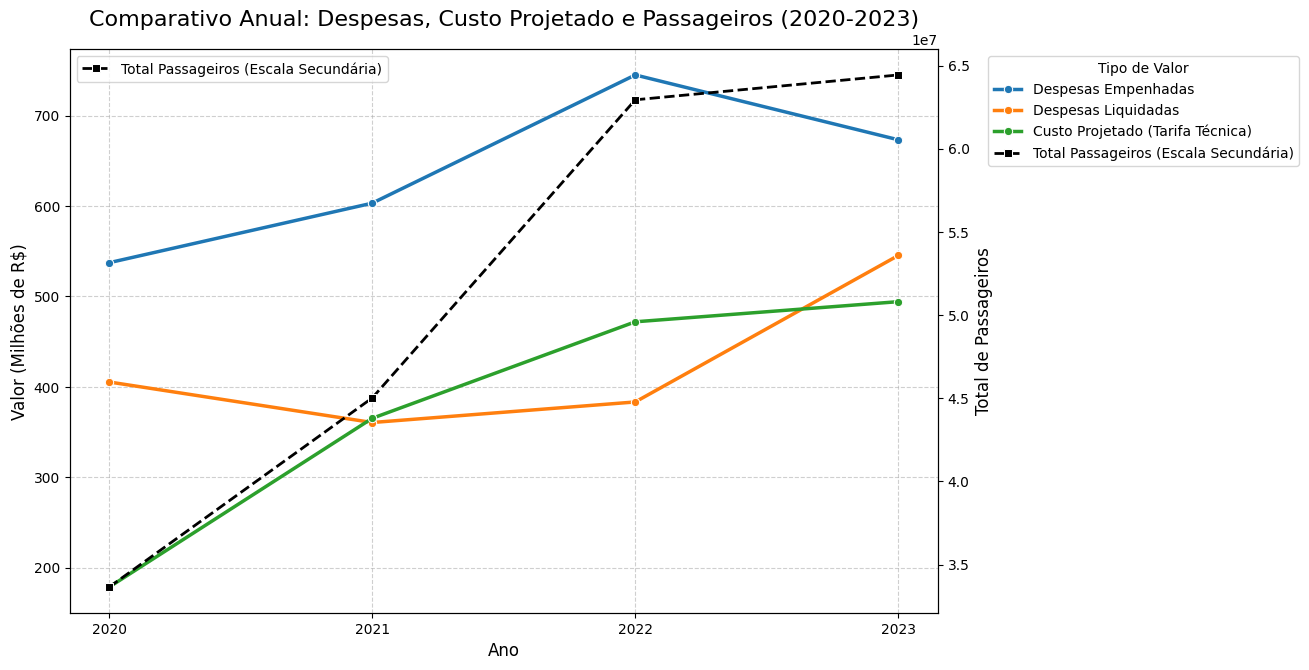

In [ ]:
# --- GRÁFICO COMPARATIVO: DESPESAS, CUSTO PROJETADO (TARIFA TÉCNICA) E PASSAGEIROS ---
print("--- Gerando Gráfico Comparativo ---")

# Usar o DataFrame final consolidado
df_plot_data = df_final_anual.copy()

# 1. Reestruturar o DataFrame para o formato longo (melt)
# Incluímos as colunas de despesas, custo anual projetado com tarifa técnica e total de passageiros
df_plot_final = df_plot_data.melt(
    id_vars='ANO',
    value_vars=['Despesas_Empenhadas_Anual', 'Despesas_Liquidadas_Anual', 'CUSTO_ANUAL_MILHOES', 'TOTAL_PASSAGEIROS_ANUAL'],
    var_name='Tipo de Valor',
    value_name='Valor'
)

# 2. Mapear nomes das colunas originais para rótulos amigáveis no gráfico
df_plot_final['Tipo de Valor'] = df_plot_final['Tipo de Valor'].map({
    'Despesas_Empenhadas_Anual': 'Despesas Empenhadas',
    'Despesas_Liquidadas_Anual': 'Despesas Liquidadas',
    'CUSTO_ANUAL_MILHOES': 'Custo Projetado (Tarifa Técnica)',
    'TOTAL_PASSAGEIROS_ANUAL': 'Total Passageiros (Escala Secundária)'
})

# Para plotar passageiros em um eixo secundário, precisamos separar os dados para o plot
df_plot_despesas_custo = df_plot_final[df_plot_final['Tipo de Valor'].isin(['Despesas Empenhadas', 'Despesas Liquidadas', 'Custo Projetado (Tarifa Técnica)'])].copy()
df_plot_passageiros = df_plot_final[df_plot_final['Tipo de Valor'] == 'Total Passageiros (Escala Secundária)'].copy()

# Converter a coluna 'Valor' para numérico, caso haja algum problema (já deveria ser float)
df_plot_despesas_custo['Valor'] = pd.to_numeric(df_plot_despesas_custo['Valor'], errors='coerce')
df_plot_passageiros['Valor'] = pd.to_numeric(df_plot_passageiros['Valor'], errors='coerce')

# Remover linhas com valores NaN na coluna 'Valor' antes de plotar
df_plot_despesas_custo = df_plot_despesas_custo.dropna(subset=['Valor'])
df_plot_passageiros = df_plot_passageiros.dropna(subset=['Valor'])


# 3. Criar o gráfico com eixo secundário
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotar Despesas e Custo Projetado no eixo primário (ax1)
sns.lineplot(data=df_plot_despesas_custo, x="ANO", y="Valor", hue="Tipo de Valor", marker='o', ax=ax1, palette='tab10', linewidth=2.5)

# Configurar eixo primário
ax1.set_title('Comparativo Anual: Despesas, Custo Projetado e Passageiros (2020-2023)', fontsize=16)
ax1.set_xlabel('Ano', fontsize=12)
ax1.set_ylabel('Valor (Milhões de R$)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xticks(df_plot_final['ANO'].unique()) # Garante que todos os anos sejam exibidos no eixo X
ax1.tick_params(axis='y')


# Criar um eixo secundário para o total de passageiros (ax2)
# Multiplicamos a escala do eixo passageiro para caber no gráfico
ax2 = ax1.twinx()
sns.lineplot(data=df_plot_passageiros, x="ANO", y="Valor", marker='s', ax=ax2, color='black', linestyle='--', label='Total Passageiros (Escala Secundária)', linewidth=2)

# Configurar eixo secundário
ax2.set_ylabel('Total de Passageiros', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_yscale('linear') # Garantir escala linear, não log

# Adicionar legendas dos dois eixos
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), title='Tipo de Valor')


plt.tight_layout(rect=[0, 0.03, 0.95, 0.98]) # Ajusta o layout para a legenda não cortar
plt.show()

plt.style.use('default')

### 4.6 - Análise do Subsídio Governamental à URBS (2020-2023)

A URBS é uma empresa municipal de economia mista, regida pela lei das sociedades anônimas. Nesta seção, calcularemos o subsídio governamental necessário para cobrir seus gastos.

Os dados para esta análise, referentes ao período de 2020 a 2023, foram obtidos no painel interativo da URBS, disponível em: [https://lookerstudio.google.com/embed/u/0/reporting/b1ccd1b5-f21a-4374-af10-bc03226b3273/page/c6jRB](https://lookerstudio.google.com/embed/u/0/reporting/b1ccd1b5-f21a-4374-af10-bc03226b3273/page/c6jRB).

A escolha deste período (2020-2023) se deve à disponibilidade dos dados de despesas (Despesas_Empenhadas_Anual, Despesas_Liquidadas_Anual), total de passageiros (TOTAL_PASSAGEIROS_ANUAL), tarifa técnica (TARIFA_TECNICA) e custo anual projetado com base na tarifa técnica (CUSTO_ANUAL_MILHOES).

#### 4.6.1 - Ano de 2020

In [ ]:
df_passageiros_2020 = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/Passageiro_P%C3%BAblico_2020.csv'
df_passageiros_2020 = pd.read_csv(df_passageiros_2020)
# Carrega o arquivo CSV de passageiros de 2020
df_passageiros_2020

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos
0,1 de mar. de 2020,117109,27918
1,2 de mar. de 2020,615010,100508
2,3 de mar. de 2020,630057,102958
3,4 de mar. de 2020,639283,109205
4,5 de mar. de 2020,640561,106268
...,...,...,...
301,27 de dez. de 2020,47275,10471
302,28 de dez. de 2020,240975,35173
303,29 de dez. de 2020,240532,35095
304,30 de dez. de 2020,230682,36222


In [ ]:
# Processa os dados de passageiros de 2020 (df_passageiros_2020)

# Verifica se o DataFrame foi lido como uma única coluna
if len(df_passageiros_2020.columns) == 1:
    nome_coluna = df_passageiros_2020.columns[0]
    df_passageiros_2020[['DATA', 'TOTAL S/ ISENTOS', 'Passageiros Isentos']] = df_passageiros_2020[nome_coluna].str.split(',', expand=True)

# Converte as novas colunas para os tipos de dados apropriados
df_passageiros_2020['TOTAL S/ ISENTOS'] = pd.to_numeric(df_passageiros_2020['TOTAL S/ ISENTOS'], errors='coerce')
df_passageiros_2020['Passageiros Isentos'] = pd.to_numeric(df_passageiros_2020['Passageiros Isentos'], errors='coerce')


# Converte a coluna 'DATA' para o formato datetime em df_passageiros_2020
# Usa a string de formato correta '%d de %b. de %Y' com base na prévia dos dados
df_passageiros_2020['DATA'] = pd.to_datetime(df_passageiros_2020['DATA'], format='%d de %b. de %Y', errors='coerce')

# Remove linhas onde a conversão de data falhou
df_passageiros_2020_cleaned = df_passageiros_2020.dropna(subset=['DATA']).copy()

# Extrai o ano da coluna 'DATA'
df_passageiros_2020_cleaned['ANO'] = df_passageiros_2020_cleaned['DATA'].dt.year

# Agrupa pelo 'ANO' extraído e soma as colunas de passageiros
df_passageiros_2020_anual = df_passageiros_2020_cleaned.groupby('ANO')[['TOTAL S/ ISENTOS', 'Passageiros Isentos']].sum().reset_index()

# Exibe o resultado
print("Dados Anuais de Passageiros para 2020:")
display(df_passageiros_2020_anual)

Dados Anuais de Passageiros para 2020:


,ANO,TOTAL S/ ISENTOS,Passageiros Isentos
0,2020,29387901,4253986


In [ ]:
df_passageiros_2020_anual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   ANO                  1 non-null      int32
 1   TOTAL S/ ISENTOS     1 non-null      int64
 2   Passageiros Isentos  1 non-null      int64
dtypes: int32(1), int64(2)
memory usage: 152.0 bytes


#### 4.6.2 - Ano de 2021

In [ ]:
file_path_passageiros_2021 = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/Passageiro_P%C3%BAblico_2021.csv'
df_passageiros_2021 = pd.read_csv(file_path_passageiros_2021)
# Carrega o arquivo CSV de passageiros de 2021
df_passageiros_2021

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos
0,1 de jan. de 2021,33575,8703
1,2 de jan. de 2021,95419,16489
2,3 de jan. de 2021,46325,11299
3,4 de jan. de 2021,271733,42414
4,5 de jan. de 2021,280883,42546
...,...,...,...
360,27 de dez. de 2021,293200,41255
361,28 de dez. de 2021,306660,45943
362,29 de dez. de 2021,292396,44856
363,30 de dez. de 2021,249297,36483


In [ ]:
df_passageiros_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATA                 365 non-null    object
 1   TOTAL S/ ISENTOS     365 non-null    int64 
 2   Passageiros Isentos  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


In [ ]:
# Processa os dados de passageiros de 2021 (df_passageiros_2021)

# --- Analisando a coluna única em múltiplas colunas (assumindo estrutura similar aos dados de 2020) ---
# Verifica se o DataFrame foi lido como uma única coluna
if len(df_passageiros_2021.columns) == 1:
    single_column_name = df_passageiros_2021.columns[0]
    df_passageiros_2021[['DATA', 'TOTAL S/ ISENTOS', 'Passageiros Isentos']] = df_passageiros_2021[single_column_name].str.split(',', expand=True)

# Converte as novas colunas para os tipos de dados apropriados
df_passageiros_2021['TOTAL S/ ISENTOS'] = pd.to_numeric(df_passageiros_2021['TOTAL S/ ISENTOS'], errors='coerce')
df_passageiros_2021['Passageiros Isentos'] = pd.to_numeric(df_passageiros_2021['Passageiros Isentos'], errors='coerce')


# Converte a coluna 'DATA' para o formato datetime em df_passageiros_2021
# Usa a string de formato correta '%d de %b. de %Y' com base na prévia dos dados
df_passageiros_2021['DATA'] = pd.to_datetime(df_passageiros_2021['DATA'], format='%d de %b. de %Y', errors='coerce')

# Remove linhas onde a conversão de data falhou
df_passageiros_2021_cleaned = df_passageiros_2021.dropna(subset=['DATA']).copy()

# Extrai o ano da coluna 'DATA'
df_passageiros_2021_cleaned['ANO'] = df_passageiros_2021_cleaned['DATA'].dt.year

# Agrupa pelo 'ANO' extraído e soma as colunas de passageiros
df_passageiros_2021_anual = df_passageiros_2021_cleaned.groupby('ANO')[['TOTAL S/ ISENTOS', 'Passageiros Isentos']].sum().reset_index()

# Exibe o resultado
print("Dados Anuais de Passageiros para 2021:")
display(df_passageiros_2021_anual)

Dados Anuais de Passageiros para 2021:


,ANO,TOTAL S/ ISENTOS,Passageiros Isentos
0,2021,39496818,5515022


#### 4.6.3 - Ano de 2022


In [ ]:
file_path_passageiros_2022 = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/Passageiro_P%C3%BAblico_2022.csv'
df_passageiros_2022 = pd.read_csv(file_path_passageiros_2022)
# Carrega o arquivo CSV de passageiros de 2021
df_passageiros_2022

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos
0,1 de jan. de 2022,47815,10860
1,2 de jan. de 2022,81396,15644
2,3 de jan. de 2022,305389,47506
3,4 de jan. de 2022,326195,51475
4,5 de jan. de 2022,344791,55722
...,...,...,...
360,27 de dez. de 2022,319675,52369
361,28 de dez. de 2022,314557,55247
362,29 de dez. de 2022,310112,52145
363,30 de dez. de 2022,266489,47849


In [ ]:
df_passageiros_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATA                 365 non-null    object
 1   TOTAL S/ ISENTOS     365 non-null    int64 
 2   Passageiros Isentos  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


In [ ]:
# Processa os dados de passageiros de 2022 (df_passageiros_2022)

# --- Análise antes do processamento ---
# Verifica se o DataFrame foi lido como uma única coluna (assumindo estrutura similar aos dados de 2020)
if len(df_passageiros_2022.columns) == 1:
    coluna_unica = df_passageiros_2022.columns[0]
    df_passageiros_2022[['DATA', 'TOTAL S/ ISENTOS', 'Passageiros Isentos']] = df_passageiros_2022[coluna_unica].str.split(',', expand=True)

# Converte as novas colunas para os tipos de dados apropriados
df_passageiros_2022['TOTAL S/ ISENTOS'] = pd.to_numeric(df_passageiros_2022['TOTAL S/ ISENTOS'], errors='coerce')
df_passageiros_2022['Passageiros Isentos'] = pd.to_numeric(df_passageiros_2022['Passageiros Isentos'], errors='coerce')


# Converte a coluna 'DATA' para o formato datetime em df_passageiros_2022
# Usa a string de formato correta '%d de %b. de %Y' com base na prévia dos dados
df_passageiros_2022['DATA'] = pd.to_datetime(df_passageiros_2022['DATA'], format='%d de %b. de %Y', errors='coerce')

# Remove linhas onde a conversão de data falhou
df_passageiros_2022_cleaned = df_passageiros_2022.dropna(subset=['DATA']).copy()

# Extrai o ano da coluna 'DATA'
df_passageiros_2022_cleaned['ANO'] = df_passageiros_2022_cleaned['DATA'].dt.year

# Agrupa pelo 'ANO' extraído e soma as colunas de passageiros
df_passageiros_2022_anual = df_passageiros_2022_cleaned.groupby('ANO')[['TOTAL S/ ISENTOS', 'Passageiros Isentos']].sum().reset_index()

# Exibe o resultado
print("Dados Anuais de Passageiros para 2022:")
display(df_passageiros_2022_anual)

Dados Anuais de Passageiros para 2022:


,ANO,TOTAL S/ ISENTOS,Passageiros Isentos
0,2022,54891526,8046693


#### 4.6.4 - Ano de 2023


In [ ]:
file_path_passageiros_2023 = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/Passageiro_P%C3%BAblico_2023.csv'
df_passageiros_2023 = pd.read_csv(file_path_passageiros_2023)
# Carrega o arquivo CSV de passageiros de 2023
df_passageiros_2023

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos
0,1 de jan. de 2023,50465,12502
1,2 de jan. de 2023,271999,47219
2,3 de jan. de 2023,339696,59902
3,4 de jan. de 2023,312378,45335
4,5 de jan. de 2023,366212,67030
...,...,...,...
357,27 de dez. de 2023,313835,66308
358,28 de dez. de 2023,306805,61030
359,29 de dez. de 2023,274618,57379
360,30 de dez. de 2023,154776,37134


In [ ]:
df_passageiros_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATA                 362 non-null    object
 1   TOTAL S/ ISENTOS     362 non-null    int64 
 2   Passageiros Isentos  362 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.6+ KB


In [ ]:
# Processa os dados de passageiros de 2023 (df_passageiros_2023)

# Converte a coluna 'DATA' para o formato datetime em df_passageiros_2023
# Usa a string de formato correta '%d de %b. de %Y' com base na prévia dos dados
df_passageiros_2023['DATA'] = pd.to_datetime(df_passageiros_2023['DATA'], format='%d de %b. de %Y', errors='coerce')

# Remove linhas onde a conversão de data falhou
df_passageiros_2023_cleaned = df_passageiros_2023.dropna(subset=['DATA']).copy()

# Extrai o ano da coluna 'DATA'
df_passageiros_2023_cleaned['ANO'] = df_passageiros_2023_cleaned['DATA'].dt.year

# Agrupa pelo 'ANO' extraído e soma as colunas de passageiros
df_passageiros_2023_anual = df_passageiros_2023_cleaned.groupby('ANO')[['TOTAL S/ ISENTOS', 'Passageiros Isentos']].sum().reset_index()

# Exibe o resultado
print("Dados Anuais de Passageiros para 2023:")
display(df_passageiros_2023_anual)

Dados Anuais de Passageiros para 2023:


,ANO,TOTAL S/ ISENTOS,Passageiros Isentos
0,2023,55047471,9385105


#### 4.6.5 - Juntando as tabelas...

In [ ]:
# Consolida os dados anuais de passageiros dos dataframes individuais de cada ano

# Lista de dataframes anuais de passageiros
passageiros_anual_dfs = [
    df_passageiros_2020_anual,
    df_passageiros_2021_anual,
    df_passageiros_2022_anual,
    df_passageiros_2023_anual
]

# Concatena os dataframes
df_passageiros_anual_consolidados = pd.concat(passageiros_anual_dfs, ignore_index=True)

# Calcula o total anual de passageiros
df_passageiros_anual_consolidados['TOTAL_PASSAGEIROS_ANUAL'] = df_passageiros_anual_consolidados['TOTAL S/ ISENTOS'] + df_passageiros_anual_consolidados['Passageiros Isentos']

# Seleciona e renomeia colunas para corresponder ao formato necessário para o cálculo do subsídio
df_anual_passageiros_para_merge = df_passageiros_anual_consolidados[['ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'Passageiros Isentos']].copy()
df_anual_passageiros_para_merge.rename(columns={'Passageiros Isentos': 'TOTAL_ISENTOS_ANUAL'}, inplace=True)


# Exibe os dados anuais consolidados de passageiros
print("Dados Anuais Consolidados de Passageiros (2020-2023):")
display(df_anual_passageiros_para_merge)

Dados Anuais Consolidados de Passageiros (2020-2023):


,ANO,TOTAL_PASSAGEIROS_ANUAL,TOTAL_ISENTOS_ANUAL
0,2020,33641887,4253986
1,2021,45011840,5515022
2,2022,62938219,8046693
3,2023,64432576,9385105


In [ ]:
df_anual_passageiros_para_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ANO                      4 non-null      int32
 1   TOTAL_PASSAGEIROS_ANUAL  4 non-null      int64
 2   TOTAL_ISENTOS_ANUAL      4 non-null      int64
dtypes: int32(1), int64(2)
memory usage: 212.0 bytes


#### 4.6.6 - Gerando o gráfico

--- Estimando o Subsídio Anual Necessário ---

Estimativa de Subsídio Anual Necessário (Milhões de R$):


,ANO,TOTAL_PASSAGEIROS_ANUAL,TOTAL_ISENTOS_ANUAL,TOTAL_PAGANTES_ANUAL_ESTIMADO,TARIFA_TECNICA,Despesas_Liquidadas_Anual,RECEITA_ESTIMADA_ANUAL,SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL_MILHOES
0,2020,33641887,4253986,29387901,5.3044,405.406387,1.558852e+08,249.521205
1,2021,45011840,5515022,39496818,8.1132,360.548937,3.204456e+08,40.103353
2,2022,62938219,8046693,54891526,7.4991,383.304745,4.116370e+08,-28.332298
3,2023,64432576,9385105,55047471,7.6709,545.389869,4.222636e+08,123.126223


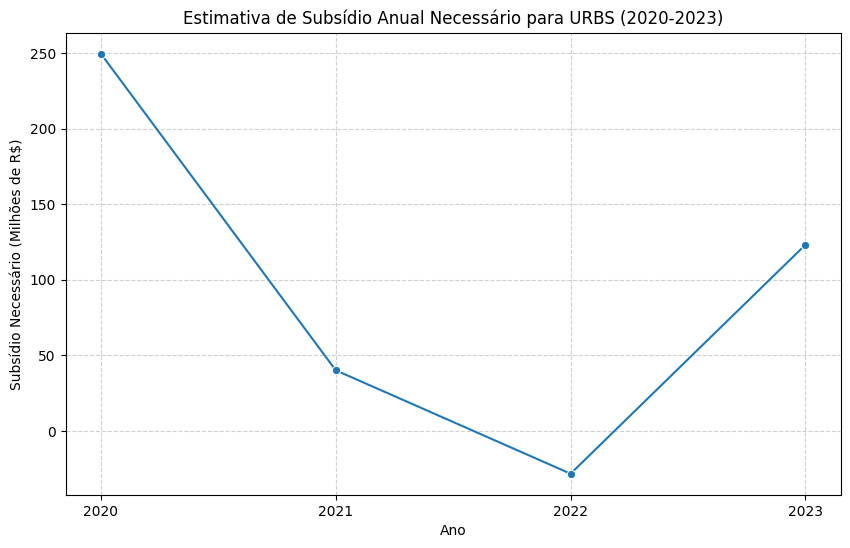

In [ ]:
print("--- Estimando o Subsídio Anual Necessário ---")


# Juntar os DataFrames anuais
# df_anual_passageiros_para_merge tem 'ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'TOTAL_ISENTOS_ANUAL'
df_subsidio_calc = pd.merge(df_anual_passageiros_para_merge, df_tarifa_anual, on='ANO', how='inner')
df_subsidio_calc = pd.merge(df_subsidio_calc, df_despesas_anual[['ANO', 'Despesas_Liquidadas_Anual']], on='ANO', how='inner')

# Preencher valores NaN com 0 após a junção, para cálculos
df_subsidio_calc = df_subsidio_calc.fillna(0)

# Calcular Passageiros Pagantes Anuais (Estimativa)
# TOTAL_PASSAGEIROS_ANUAL inclui isentos, então subtraímos os isentos para estimar pagantes
df_subsidio_calc['TOTAL_PAGANTES_ANUAL_ESTIMADO'] = df_subsidio_calc['TOTAL_PASSAGEIROS_ANUAL'] - df_subsidio_calc['TOTAL_ISENTOS_ANUAL']

# Calcular Receita Anual Estimada (apenas de passageiros pagantes)
# Usamos a tarifa técnica como proxy para a receita por passageiro pagante
df_subsidio_calc['RECEITA_ESTIMADA_ANUAL'] = df_subsidio_calc['TOTAL_PAGANTES_ANUAL_ESTIMADO'] * df_subsidio_calc['TARIFA_TECNICA']

# O subsídio necessário é a diferença entre as Despesas Liquidadas (custo real pago pelo governo)
# e a Receita Estimada dos pagantes.
# Se as despesas liquidadas forem maiores que a receita, há um subsídio.
# Convertendo Despesas_Liquidadas_Anual de milhões para unidades
df_subsidio_calc['Despesas_Liquidadas_Anual_Unidades'] = df_subsidio_calc['Despesas_Liquidadas_Anual'] * 1000000

df_subsidio_calc['SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL'] = df_subsidio_calc['Despesas_Liquidadas_Anual_Unidades'] - df_subsidio_calc['RECEITA_ESTIMADA_ANUAL']

# Convertendo o subsídio para milhões para melhor visualização
df_subsidio_calc['SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL_MILHOES'] = df_subsidio_calc['SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL'] / 1000000

# Ordenar por ano para melhor legibilidade
df_subsidio_calc = df_subsidio_calc.sort_values(by='ANO').reset_index(drop=True)

# Exibir os resultados
print("\nEstimativa de Subsídio Anual Necessário (Milhões de R$):")
display(df_subsidio_calc[['ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'TOTAL_ISENTOS_ANUAL', 'TOTAL_PAGANTES_ANUAL_ESTIMADO', 'TARIFA_TECNICA', 'Despesas_Liquidadas_Anual', 'RECEITA_ESTIMADA_ANUAL', 'SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL_MILHOES']])

# Você pode opcionalmente plotar o subsídio ao longo dos anos
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_subsidio_calc, x='ANO', y='SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL_MILHOES', marker='o')
plt.title('Estimativa de Subsídio Anual Necessário para URBS (2020-2023)')
plt.xlabel('Ano')
plt.ylabel('Subsídio Necessário (Milhões de R$)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_subsidio_calc['ANO'])
plt.show()